# Imports and Functions

In [2]:
#Pandas import
import pandas as pd
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(threshold = np.inf)
from soccerplots.radar_chart import Radar

MLS Teams array for later use

In [3]:
mls_teams = [
    "Atlanta United FC",
    "Austin FC",
    "CF Montréal",
    "Charlotte FC",
    "Chicago Fire FC",
    "Colorado Rapids",
    "Columbus Crew",
    "D.C. United",
    "FC Cincinnati",
    "FC Dallas",
    "Houston Dynamo FC",
    "Inter Miami CF",
    "LA Galaxy",
    "Los Angeles FC",
    "Minnesota United FC",
    "Nashville SC",
    "New England Revolution",
    "New York City FC",
    "New York Red Bulls",
    "Orlando City SC",
    "Philadelphia Union",
    "Portland Timbers",
    "Real Salt Lake",
    "San Jose Earthquakes",
    "Seattle Sounders FC",
    "Sporting Kansas City",
    "St. Louis CITY SC",
    "Toronto FC",
    "Vancouver Whitecaps FC"
]


Function to fix the columns names

In [4]:
def fix_column_names(df):
    for index, column in enumerate(df.columns):
        if '/' in column:
            names = column.split('/')
            first = names[0].strip()
            second = names[0].strip() + " " + names[1].strip()
            
            df.rename(columns={column: first}, inplace=True)
            df.rename(columns={df.columns[index + 1]: second}, inplace=True)
    
    return df

Function to normalize the data in 90 minutes.

In [5]:
def norm_90(df, cols):
    # Sum of given columns
    df_90 = df[cols].sum(numeric_only=True)

    # Create a column for 90m played
    df_90["90s"] = int(df_90["Minutes played"]) / 90

    df_90 = pd.DataFrame(df_90).T

    columns_to_divide = cols[2:]

    # Divide these columns by the values in the '90s' column
    df_90[columns_to_divide] = df_90[columns_to_divide].div(df_90['90s'], axis=0)

    # Drop the 90s column
    df_90.drop("90s", axis=1, inplace=True)

    # Rename the columns to per 90'
    for i in range(1, len(df_90.columns)):
        df_90.columns.values[i] = df_90.columns[i] + '/90'

    df_90["Team"] = df["Team"].iloc[0]
    
    return df_90

Concat all data and per 90 metrics

In [6]:
def team_data(df_list, cols):
    temp_list = []

    for df in df_list:
        df = norm_90(df, cols)
        temp_list.append(df)
    
    teams_df = pd.concat(temp_list)
    teams_df = teams_df.set_index("Team").rename_axis(None)

    return teams_df
     

Function to visualize a metric between all the different teams and divisions

In [7]:
def visualize_metric_between_teams(df, metric, player):
    # Generate a list of colors based on the index count using a colormap
    cmap = plt.colormaps['tab10']
    colors = cmap(np.linspace(0, 1, len(df)))

    # Create bar chart
    plt.figure(figsize=(8, 6))
    bars = plt.bar(df.index, df[metric], color=colors)
    
    # Add text to the top
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom', fontsize=10, fontweight='bold')

    plt.xticks(fontsize=8.5)

    # Add title and labels
    plt.title(f"{metric} for {player}", fontsize=14, fontweight='bold')
    plt.xlabel('')
    plt.ylabel('')

    # Show plot
    plt.show()
    

In [97]:
def passing_accuracy_per_teams(df, total, acc, player):
    # Generate a list of colors based on the index count using a colormap
    cmap = plt.colormaps['tab10']
    colors = cmap(np.linspace(0, 1, len(df)))

    # Create bar chart
    plt.figure(figsize=(8, 6))
    bars = plt.bar(df.index, df[total], color=colors)
    
    # Add text to the top
    for i, bar in enumerate(bars):
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval,  f"{round( ((df.iloc[i][acc] / yval) * 100), 1)}%", ha='center', va='bottom', fontsize=10, fontweight='bold')

    plt.xticks(fontsize=8.5)

    # Add title and labels
    plt.title(f"{total} and accuracy for {player}", fontsize=14, fontweight='bold')
    plt.xlabel('')
    plt.ylabel('')

    # Show plot
    plt.show()

Function that returns a df with a single player data separated by teams

In [8]:
def df_all_teams(df, teams, cols):

    df = fix_column_names(df)

    df_holder = []

    for team in teams:
        if ('II' in team or 'U2' in team or 'U1' in team):
            temp = df[df['Match'].str.contains(team, na=False)]
        elif (any(team in team_name for team_name in mls_teams)):
            temp = df[df['Match'].str.contains(team, na=False) & ~df['Match'].str.contains('II', na=False)]
        else:
            temp = df[df['Match'].str.contains(team, na=False) & ~df['Match'].str.contains('U2', na=False) & ~df['Match'].str.contains('U1', na=False)]

        temp["Team"] = team
        df_holder.append(temp)

    teams_df = team_data(df_holder, cols)
    return teams_df

Function for scatter plots to compare academy metrics to mls metrics

In [9]:
def scatter_mls_vs_aca(mls_df, player1_df, player1_team, player2_df, player2_team, metric_mls1, metric_mls2, metric_aca1, metric_aca2):
    
    x_mls = mls_df[metric_mls1]
    y_mls = mls_df[metric_mls2]

    fig, ax = plt.subplots()
    ax.scatter(x_mls, y_mls, color = 'black')
    
    # add vertical average line 
    ax.axvline(x=np.nanmean(x_mls), linestyle = '--', linewidth = 1)
    ax.axhline(y=np.nanmean(y_mls), linestyle = '--', linewidth = 1)

    x_aca = [player1_df.loc[player1_team, metric_aca1], player2_df.loc[player2_team, metric_aca1] ]
    y_aca = [player1_df.loc[player1_team, metric_aca2], player2_df.loc[player2_team, metric_aca2] ] 
    labels = ["Cremaschi", "McGlynn"]

    ax.scatter(x_aca, y_aca, color = 'red')

    for i, txt in enumerate(labels):
        ax.annotate(txt, (x_aca[i], y_aca[i]))

    plt.xlabel(f"{metric_mls1} per 90'")
    plt.ylabel(f"{metric_mls2} per 90'")
    plt.title(f"{metric_mls1} vs {metric_mls2} - MLS Data and Player Academy Data", fontsize=10, fontweight='bold')

    plt.show()
        

Radar chart function

In [10]:
def two_player_radar_chart(metrics, ranges, player1_df, player1_team, player1_name, player2_df, player2_team, player2_name):
    ## parameter value
    values = [
        player1_df.loc[player1_team, metrics],   
        player2_df.loc[player2_team, metrics]
    ]

    ## title
    title = dict(
        title_name=player1_name,
        title_color='red',
        title_name_2=player2_name,
        title_color_2='blue',
        title_fontsize=18
    )

    ## instantiate object
    radar = Radar(label_fontsize=7.6)

    ## plot radar -- alphas
    fig, ax = radar.plot_radar(ranges=ranges, params=metrics, values=values,
                                    radar_color=['#B6282F', '#344D94'],
                                    alphas=[0.8, 0.6], title=title,
                                    compare=True)

# Stats for Benjamin Cremaschi

Import the data from an excel from Wyscout

In [11]:
cremaschi_df = pd.read_excel("USA Data/Player stats B. Cremaschi.xlsx", )

Get a single df with all clubs and national teams together, metrics per 90'

In [12]:
cols = ["Team", 'Minutes played',
        'Total actions', 'Total actions successful', 'Goals', 'Assists',
        'Shots', 'Shots on target', 'xG', 'Passes', 'Passes accurate',
        'Long passes', 'Long passes accurate', 'Crosses', 'Crosses accurate',
        'Dribbles', 'Dribbles successful', 'Duels', 'Duels won', 'Aerial duels',
        'Aerial duels won', 'Interceptions', 'Losses', 'Losses own half',
        'Recoveries', 'Recoveries opp. half', 'Yellow card', 'Red card',
        'Defensive duels', 'Defensive duels won', 'Loose ball duels',
        'Loose ball duels won', 'Sliding tackles', 'Sliding tackles successful',
        'Clearances', 'Fouls', 'Yellow cards', 'Red cards', 'Shot assists',
        'Offensive duels', 'Offensive duels won', 'Touches in penalty area',
        'Offsides', 'Progressive runs', 'Fouls suffered', 'Through passes',
        'Through passes accurate', 'xA', 'Second assists',
        'Passes to final third', 'Passes to final third accurate',
        'Passes to penalty area', 'Passes to penalty area accurate',
        'Received passes', 'Forward passes', 'Forward passes accurate',
        'Back passes', 'Back passes accurate']

teams = ["Inter Miami", "Inter Miami II"]
cremaschi_teams_df = df_all_teams(cremaschi_df, teams, cols)
cremaschi_teams_df

,Minutes played,Total actions/90,Total actions successful/90,Goals/90,Assists/90,Shots/90,Shots on target/90,xG/90,Passes/90,Passes accurate/90,Long passes/90,Long passes accurate/90,Crosses/90,Crosses accurate/90,Dribbles/90,Dribbles successful/90,Duels/90,Duels won/90,Aerial duels/90,Aerial duels won/90,Interceptions/90,Losses/90,Losses own half/90,Recoveries/90,Recoveries opp. half/90,Yellow card/90,Red card/90,Defensive duels/90,Defensive duels won/90,Loose ball duels/90,Loose ball duels won/90,Sliding tackles/90,Sliding tackles successful/90,Clearances/90,Fouls/90,Yellow cards/90,Red cards/90,Shot assists/90,Offensive duels/90,Offensive duels won/90,Touches in penalty area/90,Offsides/90,Progressive runs/90,Fouls suffered/90,Through passes/90,Through passes accurate/90,xA/90,Second assists/90,Passes to final third/90,Passes to final third accurate/90,Passes to penalty area/90,Passes to penalty area accurate/90,Received passes/90,Forward passes/90,Forward passes accurate/90,Back passes/90,Back passes accurate/90
Inter Miami,3366.0,72.219251,46.149733,0.133690,0.133690,1.096257,0.347594,0.139305,40.320856,35.374332,1.283422,0.668449,0.748663,0.240642,2.219251,0.935829,21.764706,9.973262,2.272727,0.962567,2.700535,9.064171,3.716578,5.695187,2.513369,9.064171,0.0,8.048128,5.187166,2.566845,1.096257,0.26738,0.160428,0.695187,1.069519,0.187166,0.0,0.695187,8.877005,2.727273,1.978610,0.13369,1.203209,1.016043,0.695187,0.374332,0.103209,0.026738,3.903743,3.074866,1.497326,0.935829,31.577540,9.331551,7.192513,9.358289,8.796791
Inter Miami II,1181.0,68.204911,40.160881,0.381033,0.152413,1.066892,0.457240,0.087638,32.692633,26.977138,1.676545,0.990686,0.685859,0.304826,3.048264,1.676545,23.471634,11.354784,1.905165,0.990686,2.514818,9.602032,4.115157,6.553768,2.133785,9.068586,0.0,10.592718,6.096528,2.819644,1.066892,0.22862,0.152413,0.762066,1.600339,0.304826,0.0,0.914479,8.154107,3.200677,1.371719,0.00000,1.524132,1.295512,0.609653,0.152413,0.117358,0.152413,4.115157,2.895851,1.295512,0.533446,23.624047,10.821338,7.773074,5.563082,4.877223


# Stats for Ricardo Pepi

Import the data from an excel from Wyscout

In [13]:
pepi_df = pd.read_excel('USA Data/Player stats R. Pepi.xlsx')


Get a single df with all clubs and national teams together, metrics per 90'

In [14]:
cols = ["Team", 'Minutes played',
        'Total actions', 'Total actions successful', 'Goals', 'Assists',
        'Shots', 'Shots on target', 'xG', 'Passes', 'Passes accurate',
        'Long passes', 'Long passes accurate', 'Crosses', 'Crosses accurate',
        'Dribbles', 'Dribbles successful', 'Duels', 'Duels won', 'Aerial duels',
        'Aerial duels won', 'Interceptions', 'Losses', 'Losses own half',
        'Recoveries', 'Recoveries opp. half', 'Yellow card', 'Red card',
        'Defensive duels', 'Defensive duels won', 'Loose ball duels',
        'Loose ball duels won', 'Sliding tackles', 'Sliding tackles successful',
        'Clearances', 'Fouls', 'Yellow cards', 'Red cards', 'Shot assists',
        'Offensive duels', 'Offensive duels won', 'Touches in penalty area',
        'Offsides', 'Progressive runs', 'Fouls suffered', 'Through passes',
        'Through passes accurate', 'xA', 'Second assists',
        'Passes to final third', 'Passes to final third accurate',
        'Passes to penalty area', 'Passes to penalty area accurate',
        'Received passes', 'Forward passes', 'Forward passes accurate',
        'Back passes', 'Back passes accurate']

teams = ["Dallas", "PSV", "United States", "Groningen", "North Texas", "United States U17"]
pepi_teams_df = df_all_teams(pepi_df, teams, cols)
pepi_teams_df

,Minutes played,Total actions/90,Total actions successful/90,Goals/90,Assists/90,Shots/90,Shots on target/90,xG/90,Passes/90,Passes accurate/90,Long passes/90,Long passes accurate/90,Crosses/90,Crosses accurate/90,Dribbles/90,Dribbles successful/90,Duels/90,Duels won/90,Aerial duels/90,Aerial duels won/90,Interceptions/90,Losses/90,Losses own half/90,Recoveries/90,Recoveries opp. half/90,Yellow card/90,Red card/90,Defensive duels/90,Defensive duels won/90,Loose ball duels/90,Loose ball duels won/90,Sliding tackles/90,Sliding tackles successful/90,Clearances/90,Fouls/90,Yellow cards/90,Red cards/90,Shot assists/90,Offensive duels/90,Offensive duels won/90,Touches in penalty area/90,Offsides/90,Progressive runs/90,Fouls suffered/90,Through passes/90,Through passes accurate/90,xA/90,Second assists/90,Passes to final third/90,Passes to final third accurate/90,Passes to penalty area/90,Passes to penalty area accurate/90,Received passes/90,Forward passes/90,Forward passes accurate/90,Back passes/90,Back passes accurate/90
Dallas,3110.0,52.379421,23.064309,0.463023,0.086817,2.372990,1.186495,0.384309,19.475884,15.453376,0.463023,0.173633,0.347267,0.086817,1.765273,0.723473,17.276527,5.932476,3.183280,0.868167,1.620579,8.392283,2.749196,2.864952,1.794212,2.430868,0.0,4.745981,2.430868,3.096463,0.897106,0.231511,0.144695,0.491961,0.897106,0.028939,0.0,0.897106,6.250804,1.736334,3.675241,0.434084,0.520900,0.723473,0.665595,0.289389,0.079003,0.086817,1.186495,0.752412,0.810289,0.434084,15.163987,3.038585,1.996785,6.077170,5.440514
PSV,1159.0,53.192407,24.305436,0.776531,0.232959,2.640207,1.397757,0.587058,21.199310,16.695427,0.698878,0.388266,0.232959,0.077653,1.320104,0.621225,19.102675,5.823986,3.805004,1.009491,1.708369,9.163072,3.028473,2.407248,1.553063,19.646247,0.0,3.882657,2.329594,3.805004,1.087144,0.155306,0.077653,0.776531,0.776531,0.232959,0.0,1.009491,7.610009,1.397757,4.969802,0.543572,0.776531,0.310613,0.232959,0.077653,0.072994,0.000000,1.320104,0.854185,1.009491,0.621225,15.763589,3.572045,2.407248,6.600518,5.746333
United States,1346.0,48.945022,21.597325,0.601783,0.066865,2.741456,1.471025,0.578380,16.916790,14.576523,0.066865,0.066865,0.200594,0.133730,1.337296,0.401189,16.783061,5.215453,2.875186,0.601783,1.939079,8.023774,1.738484,3.142645,2.540862,0.000000,0.0,3.677563,2.139673,4.346211,1.671620,0.200594,0.133730,0.267459,0.735513,0.000000,0.0,0.468053,5.884101,0.802377,4.413076,0.267459,0.668648,0.200594,0.200594,0.066865,0.039450,0.000000,1.069837,0.668648,0.401189,0.200594,12.303120,2.607727,1.805349,5.817236,5.549777
Groningen,2724.0,53.359031,21.872247,0.495595,0.066079,1.916300,0.892070,0.313877,16.552863,13.281938,0.231278,0.198238,0.231278,0.099119,1.651982,0.726872,21.211454,7.202643,6.409692,1.982379,2.610132,10.308370,2.940529,2.841410,1.751101,1.949339,0.0,3.898678,2.378855,4.262115,1.288546,0.033040,0.033040,1.057269,0.627753,0.066079,0.0,0.594714,6.640969,1.552863,3.634361,0.495595,0.528634,0.198238,0.132159,0.033040,0.062775,0.066079,0.825991,0.495595,0.660793,0.429515,11.464758,1.982379,1.123348,5.748899,5.088106
North Texas,1279.0,52.212666,24.910086,0.774042,0.000000,4.010946,1.618452,0.761376,21.884285,16.958561,0.774042,0.562940,0.774042,0.211102,2.673964,1.266615,15.903049,5.981235,2.814699,1.196247,0.703675,8.936669,1.477717,2.251759,1.688819,0.000000,0.0,3.588741,2.040657,1.970289,0.703675,0.140735,0.070367,0.140735,0.281470,0.000000,0.0,0.422205,7.529320,2.040657,3.799844,0.844410,0.844410,0.211102,0.422205,0.070367,0.026036,0.000000,1.266615,0.844410,1.829554,0.985145,17.169664,4.081314,2.322127,6.755278,6.051603
United States U17,790.0,57.759494,23.582278,0.569620,0.113924,2.164557,1.367089,0.480759,18.911392,14.126582,0.227848,0.113924,0.569620,0.113924,2.050633,0.911392,22.101266,7.746835,3.645570,0.797468,1.936709,11.164557,1.594937,3.531646,2.278481,0.000000,0.0,6.379747,3.075949,3.531646,1.025316,0.000000,0.000000,0.227848,1.708861,0.000000,0.0,0.797468,8.544304,2.848101,4.329114,0.56

# Stats for Brendan Aaronson

Import the data from an excel from Wyscout

In [15]:
aaronson_df = pd.read_excel("USA Data/Player stats B. Aaronson.xlsx")

Get a single df with all clubs and national teams together, metrics per 90'

In [16]:
cols = ["Team", 'Minutes played',
        'Total actions', 'Total actions successful', 'Goals', 'Assists',
        'Shots', 'Shots on target', 'xG', 'Passes', 'Passes accurate',
        'Long passes', 'Long passes accurate', 'Crosses', 'Crosses accurate',
        'Dribbles', 'Dribbles successful', 'Duels', 'Duels won', 'Aerial duels',
        'Aerial duels won', 'Interceptions', 'Losses', 'Losses own half',
        'Recoveries', 'Recoveries opp. half', 'Yellow card', 'Red card',
        'Defensive duels', 'Defensive duels won', 'Loose ball duels',
        'Loose ball duels won', 'Sliding tackles', 'Sliding tackles successful',
        'Clearances', 'Fouls', 'Yellow cards', 'Red cards', 'Shot assists',
        'Offensive duels', 'Offensive duels won', 'Touches in penalty area',
        'Offsides', 'Progressive runs', 'Fouls suffered', 'Through passes',
        'Through passes accurate', 'xA', 'Second assists',
        'Passes to final third', 'Passes to final third accurate',
        'Passes to penalty area', 'Passes to penalty area accurate',
        'Received passes', 'Forward passes', 'Forward passes accurate',
        'Back passes', 'Back passes accurate']

teams = ["Bethlehem Steel", "Philadelphia Union", "Salzburg", "Leeds","Union Berlin","United States"]
aaronson_teams_df = df_all_teams(aaronson_df, teams, cols)
aaronson_teams_df

,Minutes played,Total actions/90,Total actions successful/90,Goals/90,Assists/90,Shots/90,Shots on target/90,xG/90,Passes/90,Passes accurate/90,Long passes/90,Long passes accurate/90,Crosses/90,Crosses accurate/90,Dribbles/90,Dribbles successful/90,Duels/90,Duels won/90,Aerial duels/90,Aerial duels won/90,Interceptions/90,Losses/90,Losses own half/90,Recoveries/90,Recoveries opp. half/90,Yellow card/90,Red card/90,Defensive duels/90,Defensive duels won/90,Loose ball duels/90,Loose ball duels won/90,Sliding tackles/90,Sliding tackles successful/90,Clearances/90,Fouls/90,Yellow cards/90,Red cards/90,Shot assists/90,Offensive duels/90,Offensive duels won/90,Touches in penalty area/90,Offsides/90,Progressive runs/90,Fouls suffered/90,Through passes/90,Through passes accurate/90,xA/90,Second assists/90,Passes to final third/90,Passes to final third accurate/90,Passes to penalty area/90,Passes to penalty area accurate/90,Received passes/90,Forward passes/90,Forward passes accurate/90,Back passes/90,Back passes accurate/90
Bethlehem Steel,1296.0,65.277778,30.625000,0.069444,0.277778,1.388889,0.486111,0.165278,28.402778,21.250000,1.388889,0.555556,0.902778,0.347222,3.472222,1.458333,21.666667,8.055556,3.958333,0.972222,2.361111,12.847222,3.402778,4.583333,2.569444,0.416667,0.000000,5.416667,2.847222,3.888889,1.527778,0.347222,0.208333,0.902778,1.041667,0.069444,0.000000,0.972222,8.402778,2.708333,2.569444,0.069444,0.972222,1.041667,1.388889,0.486111,0.105556,0.138889,3.958333,2.222222,2.083333,1.041667,20.555556,7.569444,4.305556,6.875000,6.180556
Philadelphia Union,4312.0,63.116883,31.725417,0.146104,0.125232,1.523655,0.542672,0.185969,25.317718,20.809369,0.521800,0.187848,0.876623,0.229592,3.840445,1.440167,22.771336,9.162801,1.628015,0.459184,2.671614,8.703618,2.421150,4.800557,2.692486,1.941095,0.000000,7.785250,4.341373,3.715213,1.335807,0.125232,0.041744,0.292208,0.730519,0.062616,0.000000,0.980983,9.642857,3.026438,2.984694,0.125232,1.419295,1.461039,0.960111,0.354824,0.101647,0.125232,2.045455,1.377551,1.607143,0.814007,18.847403,6.553803,4.696197,5.865028,5.447588
Salzburg,5436.0,65.678808,33.029801,0.264901,0.264901,1.804636,0.695364,0.229139,28.642384,21.937086,1.341060,0.513245,1.672185,0.480132,3.973510,1.903974,22.417219,9.139073,2.798013,0.596026,2.384106,11.986755,3.162252,4.718543,2.731788,1.456954,0.000000,5.231788,3.228477,4.039735,1.274834,0.082781,0.033113,0.248344,0.794702,0.016556,0.000000,1.440397,10.347682,4.039735,3.658940,0.413907,1.324503,1.821192,1.274834,0.347682,0.167881,0.066225,2.864238,1.721854,2.996689,1.440397,20.264901,7.384106,4.420530,6.639073,6.192053
Leeds,3117.0,67.478345,32.743022,0.028874,0.173244,1.241578,0.317613,0.155053,26.217517,20.875842,0.692974,0.259865,1.126083,0.173244,3.666987,2.050048,23.878730,10.076997,1.963426,0.230991,2.107796,11.116458,2.656400,4.533205,2.656400,3.695861,0.000000,6.352262,4.128970,3.984601,1.126083,0.115496,0.086622,0.259865,0.577478,0.057748,0.000000,1.385948,11.578441,4.590953,2.454283,0.230991,1.559192,1.905679,0.635226,0.230991,0.151299,0.028874,2.887392,1.992300,1.616939,0.721848,18.941290,6.900866,4.706449,6.467757,5.976901
Union Berlin,1969.0,68.334180,36.338243,0.182834,0.091417,1.234129,0.502793,0.140782,27.927882,23.174200,0.502793,0.319959,1.142712,0.365668,4.845099,2.468258,26.145251,11.244286,2.148299,0.548502,2.559675,10.330117,2.696800,6.079228,3.062468,2.513966,0.959878,7.221940,4.479431,3.930929,1.234129,0.000000,0.000000,0.274251,0.822753,0.091417,0.045708,0.914170,12.844083,4.982224,2.194007,0.274251,2.239716,1.828339,0.411376,0.137125,0.116100,0.045708,2.833926,2.376841,1.965465,1.005587,19.654647,8.684611,6.536313,6.262062,6.033520
United States,2069.0,63.291445,33.711938,0.347994,0.130498,1.826970,0.869986,0.292315,24.968584,21.445143,0.695988,0.391493,1.174480,0.391493,3.523441,1.739971,22.663122,10.091832,1.174480,0.391493,2.218463,8.960851,2.174964,4.523925,2.870952,0.000000,0.000000,8.612856,4.828420,3.088449,1.043983,0.130498,0.086

# Stats for Caleb Wiley

Import the data from an excel from Wyscout

In [17]:
wiley_df = pd.read_excel("USA Data/Player stats C. Wiley.xlsx")

Get a single df with all clubs and national teams together, metrics per 90'

In [18]:
cols = ["Team", 'Minutes played',
       'Total actions', 'Total actions successful', 'Goals', 'Assists',
       'Shots', 'Shots on target', 'xG', 'Passes', 'Passes accurate',
       'Long passes', 'Long passes accurate', 'Crosses', 'Crosses accurate',
       'Dribbles', 'Dribbles successful', 'Duels', 'Duels won',
       'Interceptions', 'Losses', 'Losses own half', 'Recoveries',
       'Recoveries opp. half', 'Yellow card', 'Red card', 'Defensive duels',
       'Defensive duels won', 'Loose ball duels', 'Loose ball duels won',
       'Sliding tackles', 'Sliding tackles successful', 'Clearances', 'Fouls',
       'Yellow cards', 'Red cards', 'Shot assists', 'Offensive duels',
       'Offensive duels won', 'Touches in penalty area', 'Offsides',
       'Progressive runs', 'Fouls suffered', 'Through passes',
       'Through passes accurate', 'xA', 'Second assists',
       'Passes to final third', 'Passes to final third accurate',
       'Passes to penalty area', 'Passes to penalty area accurate',
       'Received passes', 'Forward passes', 'Forward passes accurate',
       'Back passes', 'Back passes accurate']

teams = ["Atlanta United",  "Atlanta United II", "United States U23","United States U20","United States U16"]
wiley_teams_df = df_all_teams(wiley_df, teams, cols)
wiley_teams_df

,Minutes played,Total actions/90,Total actions successful/90,Goals/90,Assists/90,Shots/90,Shots on target/90,xG/90,Passes/90,Passes accurate/90,Long passes/90,Long passes accurate/90,Crosses/90,Crosses accurate/90,Dribbles/90,Dribbles successful/90,Duels/90,Duels won/90,Interceptions/90,Losses/90,Losses own half/90,Recoveries/90,Recoveries opp. half/90,Yellow card/90,Red card/90,Defensive duels/90,Defensive duels won/90,Loose ball duels/90,Loose ball duels won/90,Sliding tackles/90,Sliding tackles successful/90,Clearances/90,Fouls/90,Yellow cards/90,Red cards/90,Shot assists/90,Offensive duels/90,Offensive duels won/90,Touches in penalty area/90,Offsides/90,Progressive runs/90,Fouls suffered/90,Through passes/90,Through passes accurate/90,xA/90,Second assists/90,Passes to final third/90,Passes to final third accurate/90,Passes to penalty area/90,Passes to penalty area accurate/90,Received passes/90,Forward passes/90,Forward passes accurate/90,Back passes/90,Back passes accurate/90
Atlanta United,6633.0,61.289009,39.036635,0.081411,0.081411,0.298507,0.149254,0.051696,37.951153,31.112619,2.537313,1.180461,2.225237,0.719132,2.021710,1.004071,15.006784,6.580733,4.518318,9.321574,3.934871,6.689281,2.008141,2.293080,0.0,6.417910,3.392130,1.967436,0.664858,0.054274,0.000000,1.451832,1.004071,0.054274,0.0,0.705563,4.572592,1.682497,1.981004,0.067843,2.021710,0.502035,0.257802,0.135685,0.087246,0.040706,3.188602,2.279512,1.858887,1.004071,28.710991,11.994573,8.873813,8.100407,7.557666
Atlanta United II,3014.0,65.424685,41.446583,0.000000,0.059721,0.298607,0.059721,0.013736,39.147313,30.816191,3.374253,1.731918,2.896483,0.985401,2.568016,1.373590,17.617784,8.898474,5.643663,10.719973,4.359655,8.271400,2.090246,6.987392,0.0,8.122097,4.568679,2.149967,0.985401,0.507631,0.358328,1.731918,0.686795,0.119443,0.0,0.925680,5.046450,2.060385,1.224287,0.238885,2.269409,0.567352,0.388188,0.119443,0.102422,0.000000,3.971466,2.657598,2.777040,1.343729,28.039151,14.392833,10.182482,8.480425,8.002654
United States U23,155.0,67.354839,45.870968,0.000000,0.000000,0.000000,0.000000,0.000000,42.967742,33.677419,1.741935,0.000000,0.000000,0.000000,1.161290,0.000000,17.419355,9.290323,5.806452,13.935484,8.709677,9.290323,2.322581,0.000000,0.0,6.967742,5.806452,1.741935,1.161290,0.000000,0.000000,1.741935,0.000000,0.000000,0.0,0.580645,6.967742,1.161290,0.580645,0.000000,0.580645,0.580645,0.000000,0.000000,0.011613,0.000000,4.064516,3.483871,0.000000,0.000000,28.451613,19.161290,12.193548,5.806452,5.225806
United States U20,617.0,66.807131,42.009724,0.145867,0.000000,0.437601,0.291734,0.153160,41.280389,32.236629,2.771475,1.312804,3.938412,1.604538,3.792545,1.896272,16.774716,7.876823,4.521880,9.918963,3.354943,7.001621,3.354943,0.000000,0.0,5.397083,3.646677,2.771475,0.583468,0.291734,0.145867,2.042139,0.875203,0.000000,0.0,1.166937,7.001621,2.479741,2.771475,0.291734,2.042139,0.875203,0.145867,0.000000,0.106483,0.000000,3.646677,2.917342,2.479741,1.166937,31.507293,10.064830,7.001621,12.690438,11.377634
United States U16,94.0,80.425532,58.404255,0.000000,0.000000,0.000000,0.000000,0.000000,58.404255,50.744681,2.872340,1.914894,1.914894,1.914894,1.914894,0.957447,14.361702,3.829787,4.787234,4.787234,2.872340,9.574468,4.787234,0.000000,0.0,3.829787,1.914894,2.872340,0.000000,0.000000,0.000000,0.957447,0.957447,0.000000,0.0,0.000000,6.702128,1.914894,0.957447,0.000000,0.957447,0.000000,0.000000,0.000000,0.000000,0.000000,4.787234,2.872340,0.957447,0.957447,42.127660,22.021277,18.191489,10.531915,10.531915


# Stats for Noah Cobb

Import the data from an excel from Wyscout

In [19]:
cobb_df = pd.read_excel("USA Data/Player stats N. Cobb.xlsx")

Get a single df with all clubs and national teams together, metrics per 90'

In [20]:
cols = ["Team",'Minutes played',
       'Total actions', 'Total actions successful', 'Goals', 'Assists',
       'Shots', 'Shots on target', 'xG', 'Passes', 'Passes accurate',
       'Long passes', 'Long passes accurate', 'Crosses', 'Crosses accurate',
       'Dribbles', 'Dribbles successful', 'Duels', 'Duels won', 'Aerial duels',
       'Aerial duels won', 'Interceptions', 'Losses', 'Losses own half',
       'Recoveries', 'Recoveries opp. half', 'Yellow card', 'Red card',
       'Defensive duels', 'Defensive duels won', 'Loose ball duels',
       'Loose ball duels won', 'Sliding tackles', 'Sliding tackles successful',
       'Clearances', 'Fouls', 'Yellow cards', 'Red cards', 'Shot assists',
       'Offensive duels', 'Offensive duels won', 'Touches in penalty area',
       'Offsides', 'Progressive runs', 'Fouls suffered', 'Through passes',
       'Through passes accurate', 'xA', 'Second assists',
       'Passes to final third', 'Passes to final third accurate',
       'Passes to penalty area', 'Passes to penalty area accurate',
       'Received passes', 'Forward passes', 'Forward passes accurate',
       'Back passes', 'Back passes accurate']

teams = ["Atlanta United",  "Atlanta United II"]
cobb_teams_df = df_all_teams(cobb_df, teams, cols)
cobb_teams_df

,Minutes played,Total actions/90,Total actions successful/90,Goals/90,Assists/90,Shots/90,Shots on target/90,xG/90,Passes/90,Passes accurate/90,Long passes/90,Long passes accurate/90,Crosses/90,Crosses accurate/90,Dribbles/90,Dribbles successful/90,Duels/90,Duels won/90,Aerial duels/90,Aerial duels won/90,Interceptions/90,Losses/90,Losses own half/90,Recoveries/90,Recoveries opp. half/90,Yellow card/90,Red card/90,Defensive duels/90,Defensive duels won/90,Loose ball duels/90,Loose ball duels won/90,Sliding tackles/90,Sliding tackles successful/90,Clearances/90,Fouls/90,Yellow cards/90,Red cards/90,Shot assists/90,Offensive duels/90,Offensive duels won/90,Touches in penalty area/90,Offsides/90,Progressive runs/90,Fouls suffered/90,Through passes/90,Through passes accurate/90,xA/90,Second assists/90,Passes to final third/90,Passes to final third accurate/90,Passes to penalty area/90,Passes to penalty area accurate/90,Received passes/90,Forward passes/90,Forward passes accurate/90,Back passes/90,Back passes accurate/90
Atlanta United,1661.0,64.316677,48.332330,0.000000,0.000000,0.054184,0.054184,0.019506,46.598435,40.909091,6.556291,3.088501,0.054184,0.054184,0.216737,0.054184,11.920530,6.502107,3.738712,1.788079,4.822396,7.531607,4.388922,9.265503,1.679711,4.551475,0.000000,5.743528,3.630343,1.788079,0.975316,0.433474,0.270921,3.196869,0.541842,0.108368,0.000000,0.108368,0.650211,0.108368,0.108368,0.0,0.379290,0.270921,0.541842,0.054184,0.007044,0.000000,3.792896,2.167369,0.487658,0.108368,33.865141,17.772426,13.329320,3.630343,3.576159
Atlanta United II,4620.0,71.240260,53.064935,0.058442,0.019481,0.116883,0.077922,0.019091,51.214286,43.753247,8.649351,4.402597,0.019481,0.019481,0.175325,0.097403,11.688312,6.915584,2.357143,1.402597,5.824675,8.181818,4.889610,9.564935,1.032468,6.545455,2.318182,6.759740,4.383117,1.831169,0.857143,0.584416,0.311688,2.961039,0.681818,0.116883,0.038961,0.038961,0.740260,0.272727,0.155844,0.0,0.155844,0.311688,0.701299,0.194805,0.003312,0.019481,4.889610,2.707792,0.428571,0.097403,36.720779,20.571429,14.980519,2.337662,2.220779


# Stats for Q. Sullivan

Import the data from an excel from Wyscout

In [21]:
sullivan_df = pd.read_excel("USA Data/Player stats Q. Sullivan.xlsx")


Get a single df with all clubs and national teams together, metrics per 90'

In [22]:
cols = ["Team", 'Minutes played',
       'Total actions', 'Total actions successful', 'Goals', 'Assists',
       'Shots', 'Shots on target', 'xG', 'Passes', 'Passes accurate',
       'Long passes', 'Long passes accurate', 'Crosses', 'Crosses accurate',
       'Dribbles', 'Dribbles successful', 'Duels', 'Duels won', 'Aerial duels',
       'Aerial duels won', 'Interceptions', 'Losses', 'Losses own half',
       'Recoveries', 'Recoveries opp. half', 'Yellow card', 'Red card',
       'Defensive duels', 'Defensive duels won', 'Loose ball duels',
       'Loose ball duels won', 'Sliding tackles', 'Sliding tackles successful',
       'Clearances', 'Fouls', 'Yellow cards', 'Red cards', 'Shot assists',
       'Offensive duels', 'Offensive duels won', 'Touches in penalty area',
       'Offsides', 'Progressive runs', 'Fouls suffered', 'Through passes',
       'Through passes accurate', 'xA', 'Second assists',
       'Passes to final third', 'Passes to final third accurate',
       'Passes to penalty area', 'Passes to penalty area accurate',
       'Received passes', 'Forward passes', 'Forward passes accurate',
       'Back passes', 'Back passes accurate']

teams = ["Philadelphia Union",  "Philadelphia Union II"]
sullivan_teams_df = df_all_teams(sullivan_df, teams, cols)
sullivan_teams_df

,Minutes played,Total actions/90,Total actions successful/90,Goals/90,Assists/90,Shots/90,Shots on target/90,xG/90,Passes/90,Passes accurate/90,Long passes/90,Long passes accurate/90,Crosses/90,Crosses accurate/90,Dribbles/90,Dribbles successful/90,Duels/90,Duels won/90,Aerial duels/90,Aerial duels won/90,Interceptions/90,Losses/90,Losses own half/90,Recoveries/90,Recoveries opp. half/90,Yellow card/90,Red card/90,Defensive duels/90,Defensive duels won/90,Loose ball duels/90,Loose ball duels won/90,Sliding tackles/90,Sliding tackles successful/90,Clearances/90,Fouls/90,Yellow cards/90,Red cards/90,Shot assists/90,Offensive duels/90,Offensive duels won/90,Touches in penalty area/90,Offsides/90,Progressive runs/90,Fouls suffered/90,Through passes/90,Through passes accurate/90,xA/90,Second assists/90,Passes to final third/90,Passes to final third accurate/90,Passes to penalty area/90,Passes to penalty area accurate/90,Received passes/90,Forward passes/90,Forward passes accurate/90,Back passes/90,Back passes accurate/90
Philadelphia Union,4412.0,57.239347,29.700816,0.163191,0.142792,1.835902,0.815956,0.171351,26.294198,20.460109,1.366727,0.713962,2.672257,0.775159,3.263826,1.958296,18.236627,7.364007,2.345875,0.632366,2.060290,9.934270,2.203083,3.875793,2.264279,8.81233,0.0,5.120127,2.835449,2.855848,0.938350,0.632366,0.203989,0.489574,1.060743,0.142792,0.0,0.979148,7.914778,2.957842,3.182230,0.244787,2.345875,0.367180,0.285585,0.122393,0.14524,0.081596,2.141886,1.529918,2.733454,1.325929,20.358114,5.874887,4.079782,6.180870,5.711695
Philadelphia Union II,1428.0,66.680672,35.168067,0.189076,0.252101,2.142857,1.071429,0.218697,31.323529,22.626050,3.025210,1.260504,3.340336,1.197479,4.222689,1.890756,20.294118,9.201681,1.827731,0.378151,2.521008,11.659664,2.268908,4.915966,2.962185,0.00000,0.0,8.319328,4.474790,2.394958,1.071429,1.071429,0.693277,0.378151,1.764706,0.000000,0.0,1.071429,7.752101,3.277311,4.222689,0.315126,2.773109,0.441176,1.071429,0.315126,0.22500,0.126050,5.294118,3.214286,4.915966,2.268908,22.121849,10.021008,6.680672,5.231092,4.726891


# Stats for D. Luna

Import the data from an excel from Wyscout

In [23]:
luna_df = pd.read_excel("USA Data/Player stats D. Luna.xlsx")

Get a single df with all clubs and national teams together, metrics per 90'

In [24]:
cols = ["Team", 'Minutes played',
       'Total actions', 'Total actions successful', 'Goals', 'Assists',
       'Shots', 'Shots on target', 'xG', 'Passes', 'Passes accurate',
       'Long passes', 'Long passes accurate', 'Crosses', 'Crosses accurate',
       'Dribbles', 'Dribbles successful', 'Duels', 'Duels won',
       'Interceptions', 'Losses', 'Losses own half', 'Recoveries',
       'Recoveries opp. half', 'Yellow card', 'Red card', 'Defensive duels',
       'Defensive duels won', 'Loose ball duels', 'Loose ball duels won',
       'Sliding tackles', 'Sliding tackles successful', 'Clearances', 'Fouls',
       'Yellow cards', 'Red cards', 'Shot assists', 'Offensive duels',
       'Offensive duels won', 'Touches in penalty area', 'Offsides',
       'Progressive runs', 'Fouls suffered', 'Through passes',
       'Through passes accurate', 'xA', 'Second assists',
       'Passes to final third', 'Passes to final third accurate',
       'Passes to penalty area', 'Passes to penalty area accurate',
       'Received passes', 'Forward passes', 'Forward passes accurate',
       'Back passes', 'Back passes accurate']

teams = ["Real Salt Lake",  "El Paso Locomotive", "United States U20"]
luna_teams_df = df_all_teams(luna_df, teams, cols)
luna_teams_df

,Minutes played,Total actions/90,Total actions successful/90,Goals/90,Assists/90,Shots/90,Shots on target/90,xG/90,Passes/90,Passes accurate/90,Long passes/90,Long passes accurate/90,Crosses/90,Crosses accurate/90,Dribbles/90,Dribbles successful/90,Duels/90,Duels won/90,Interceptions/90,Losses/90,Losses own half/90,Recoveries/90,Recoveries opp. half/90,Yellow card/90,Red card/90,Defensive duels/90,Defensive duels won/90,Loose ball duels/90,Loose ball duels won/90,Sliding tackles/90,Sliding tackles successful/90,Clearances/90,Fouls/90,Yellow cards/90,Red cards/90,Shot assists/90,Offensive duels/90,Offensive duels won/90,Touches in penalty area/90,Offsides/90,Progressive runs/90,Fouls suffered/90,Through passes/90,Through passes accurate/90,xA/90,Second assists/90,Passes to final third/90,Passes to final third accurate/90,Passes to penalty area/90,Passes to penalty area accurate/90,Received passes/90,Forward passes/90,Forward passes accurate/90,Back passes/90,Back passes accurate/90
Real Salt Lake,3947.0,67.357487,43.027616,0.250823,0.114011,1.459336,0.592855,0.163491,38.923233,33.268305,1.983785,1.254117,0.524449,0.205219,3.351913,1.983785,17.648847,8.094756,2.599443,9.622498,2.827464,5.130479,2.736255,7.866734,0.00000,5.016468,3.123892,2.211806,0.775272,0.342032,0.182417,0.387636,0.843679,0.114011,0.000000,1.527743,9.508487,3.944768,2.052192,0.136813,2.189004,1.140106,0.638460,0.228021,0.109906,0.114011,5.039270,3.807955,1.573347,1.048898,30.167216,8.619204,6.430200,9.645300,9.029643
El Paso Locomotive,3176.0,74.442695,47.947103,0.368388,0.198363,2.125315,1.105164,0.277141,42.081234,35.875315,1.388539,0.878463,1.246851,0.453401,6.886020,3.513854,21.338161,9.748111,1.785264,10.031486,2.437028,3.797229,2.352015,21.338161,2.18199,4.845718,2.805416,2.607053,0.991814,0.510076,0.198363,0.085013,1.105164,0.283375,0.028338,1.558564,13.120277,5.752519,3.258816,0.113350,3.598866,1.586902,0.850126,0.311713,0.183627,0.198363,5.214106,3.967254,2.720403,1.643577,32.984887,10.824937,8.132872,9.124685,8.727960
United States U20,1294.0,76.367852,49.729521,0.347759,0.417311,2.225657,0.834621,0.436785,45.486862,39.227202,2.503864,1.599691,0.695518,0.347759,5.772798,3.129830,19.335394,8.554869,1.947450,9.459042,2.156105,4.451314,3.129830,13.284389,0.00000,4.381762,2.573416,2.225657,0.765070,0.208655,0.069552,0.208655,0.695518,0.208655,0.000000,1.808346,12.102009,4.938176,2.990726,0.139104,2.364760,0.973725,1.112828,0.556414,0.195440,0.069552,6.468315,5.355487,3.199382,2.156105,34.775889,12.867079,10.224111,10.502318,9.806801


# Stats for T. Tessman

Import the data from an excel from Wyscout

In [25]:
tessman_df = pd.read_excel("USA Data/Player stats T. Tessmann.xlsx")

Get a single df with all clubs and national teams together, metrics per 90'

In [26]:
cols = ["Team", 'Minutes played',
       'Total actions', 'Total actions successful', 'Goals', 'Assists',
       'Shots', 'Shots on target', 'xG', 'Passes', 'Passes accurate',
       'Long passes', 'Long passes accurate', 'Crosses', 'Crosses accurate',
       'Dribbles', 'Dribbles successful', 'Duels', 'Duels won',
       'Interceptions', 'Losses', 'Losses own half', 'Recoveries',
       'Recoveries opp. half', 'Yellow card', 'Red card', 'Defensive duels',
       'Defensive duels won', 'Loose ball duels', 'Loose ball duels won',
       'Sliding tackles', 'Sliding tackles successful', 'Clearances', 'Fouls',
       'Yellow cards', 'Red cards', 'Shot assists', 'Offensive duels',
       'Offensive duels won', 'Touches in penalty area', 'Offsides',
       'Progressive runs', 'Fouls suffered', 'Through passes',
       'Through passes accurate', 'xA', 'Second assists',
       'Passes to final third', 'Passes to final third accurate',
       'Passes to penalty area', 'Passes to penalty area accurate',
       'Received passes', 'Forward passes', 'Forward passes accurate',
       'Back passes', 'Back passes accurate']

teams = ["Venezia", "North Texas", "Dallas"]
tessman_teams_df = df_all_teams(tessman_df, teams, cols)
tessman_teams_df

,Minutes played,Total actions/90,Total actions successful/90,Goals/90,Assists/90,Shots/90,Shots on target/90,xG/90,Passes/90,Passes accurate/90,Long passes/90,Long passes accurate/90,Crosses/90,Crosses accurate/90,Dribbles/90,Dribbles successful/90,Duels/90,Duels won/90,Interceptions/90,Losses/90,Losses own half/90,Recoveries/90,Recoveries opp. half/90,Yellow card/90,Red card/90,Defensive duels/90,Defensive duels won/90,Loose ball duels/90,Loose ball duels won/90,Sliding tackles/90,Sliding tackles successful/90,Clearances/90,Fouls/90,Yellow cards/90,Red cards/90,Shot assists/90,Offensive duels/90,Offensive duels won/90,Touches in penalty area/90,Offsides/90,Progressive runs/90,Fouls suffered/90,Through passes/90,Through passes accurate/90,xA/90,Second assists/90,Passes to final third/90,Passes to final third accurate/90,Passes to penalty area/90,Passes to penalty area accurate/90,Received passes/90,Forward passes/90,Forward passes accurate/90,Back passes/90,Back passes accurate/90
Venezia,7756.0,71.387313,47.761733,0.116039,0.046416,1.322847,0.406137,0.100026,45.394533,37.654719,6.707065,3.782878,0.986333,0.313306,2.088706,1.137184,16.605209,7.890665,4.363074,9.225116,3.527592,7.670191,3.388345,9.979371,2.065498,5.477050,3.283909,2.831356,1.044353,0.278494,0.127643,1.566529,0.928314,0.162455,0.023208,0.638216,5.964415,2.460031,0.649819,0.023208,1.415678,1.044353,1.160392,0.371325,0.071828,0.092831,8.598504,6.068850,2.251160,0.847086,32.502579,13.100825,8.714544,5.894791,5.651109
North Texas,978.0,74.815951,45.460123,0.092025,0.000000,2.300613,0.736196,0.122393,41.042945,32.944785,6.257669,3.036810,0.552147,0.092025,3.128834,1.656442,22.638037,10.582822,2.392638,10.582822,3.404908,6.533742,3.588957,7.177914,0.000000,7.546012,4.877301,2.944785,1.104294,0.276074,0.184049,1.104294,1.472393,0.184049,0.000000,0.736196,8.834356,3.128834,1.012270,0.184049,1.104294,1.104294,1.380368,0.368098,0.063497,0.000000,7.822086,5.153374,2.944785,1.380368,29.631902,12.975460,8.742331,6.809816,6.073620
Dallas,1840.0,72.097826,48.472826,0.000000,0.048913,1.173913,0.195652,0.028859,45.146739,38.103261,6.945652,3.815217,0.586957,0.244565,2.103261,1.125000,18.635870,8.804348,3.913043,7.728261,3.179348,8.266304,3.277174,1.516304,0.000000,6.847826,3.913043,2.641304,0.782609,0.293478,0.146739,1.222826,0.880435,0.048913,0.000000,0.635870,6.065217,2.494565,0.489130,0.000000,1.418478,0.635870,0.929348,0.146739,0.042554,0.000000,7.434783,4.842391,1.565217,0.586957,32.527174,11.983696,8.119565,6.358696,6.114130


# Stats for J. Ferreira

Import the data from an excel from Wyscout and fix the column names

In [27]:
ferreira_df = pd.read_excel("USA Data/Player stats J. Ferreira.xlsx")

Get a single df with all clubs and national teams together, metrics per 90'

In [28]:
cols = ["Team", 'Minutes played',
       'Total actions', 'Total actions successful', 'Goals', 'Assists',
       'Shots', 'Shots on target', 'xG', 'Passes', 'Passes accurate',
       'Long passes', 'Long passes accurate', 'Crosses', 'Crosses accurate',
       'Dribbles', 'Dribbles successful', 'Duels', 'Duels won',
       'Interceptions', 'Losses', 'Losses own half', 'Recoveries',
       'Recoveries opp. half', 'Yellow card', 'Red card', 'Defensive duels',
       'Defensive duels won', 'Loose ball duels', 'Loose ball duels won',
       'Sliding tackles', 'Sliding tackles successful', 'Clearances', 'Fouls',
       'Yellow cards', 'Red cards', 'Shot assists', 'Offensive duels',
       'Offensive duels won', 'Touches in penalty area', 'Offsides',
       'Progressive runs', 'Fouls suffered', 'Through passes',
       'Through passes accurate', 'xA', 'Second assists',
       'Passes to final third', 'Passes to final third accurate',
       'Passes to penalty area', 'Passes to penalty area accurate',
       'Received passes', 'Forward passes', 'Forward passes accurate',
       'Back passes', 'Back passes accurate']

teams = ["Dallas", "Tulsa Roughnecks", "United States"]
ferreira_teams_df = df_all_teams(ferreira_df, teams, cols)
ferreira_teams_df

,Minutes played,Total actions/90,Total actions successful/90,Goals/90,Assists/90,Shots/90,Shots on target/90,xG/90,Passes/90,Passes accurate/90,Long passes/90,Long passes accurate/90,Crosses/90,Crosses accurate/90,Dribbles/90,Dribbles successful/90,Duels/90,Duels won/90,Interceptions/90,Losses/90,Losses own half/90,Recoveries/90,Recoveries opp. half/90,Yellow card/90,Red card/90,Defensive duels/90,Defensive duels won/90,Loose ball duels/90,Loose ball duels won/90,Sliding tackles/90,Sliding tackles successful/90,Clearances/90,Fouls/90,Yellow cards/90,Red cards/90,Shot assists/90,Offensive duels/90,Offensive duels won/90,Touches in penalty area/90,Offsides/90,Progressive runs/90,Fouls suffered/90,Through passes/90,Through passes accurate/90,xA/90,Second assists/90,Passes to final third/90,Passes to final third accurate/90,Passes to penalty area/90,Passes to penalty area accurate/90,Received passes/90,Forward passes/90,Forward passes accurate/90,Back passes/90,Back passes accurate/90
Dallas,13936.0,58.258467,31.502583,0.355195,0.193743,2.079506,0.929966,0.299785,31.011768,24.256602,2.880310,1.394948,1.265786,0.445608,1.633898,0.794346,11.036883,4.830654,1.853473,8.188863,1.963261,3.364667,1.937428,7.355769,0.0,4.171929,2.447618,1.924512,0.710390,0.116246,0.064581,0.716848,0.555396,0.109788,0.0,1.356200,4.029851,1.478904,2.473450,0.200201,1.175373,0.484357,1.562859,0.497273,0.145307,0.071039,4.475459,2.744690,2.738232,1.369116,23.978904,7.949914,4.901693,6.961825,6.535591
Tulsa Roughnecks,1021.0,46.013712,20.450539,0.528893,0.176298,2.291871,1.234084,0.385211,17.100881,14.015671,0.617042,0.264447,0.528893,0.264447,2.115573,0.705191,12.428991,4.583741,1.674829,5.817826,1.586680,2.908913,1.674829,14.368266,0.0,4.760039,2.908913,2.027424,0.440744,0.264447,0.176298,0.352595,0.617042,0.176298,0.0,1.586680,4.495593,1.145935,2.997062,0.352595,0.881489,0.000000,0.440744,0.088149,0.165720,0.000000,1.939275,1.674829,1.586680,1.145935,12.428991,4.848188,4.054848,3.349657,2.908913
United States,1529.0,54.094179,24.486593,0.882930,0.235448,2.884238,1.589274,0.617462,24.545455,18.600392,1.471550,0.647482,0.706344,0.235448,1.471550,0.706344,12.125572,4.061478,2.060170,9.064748,2.001308,3.178548,2.119032,4.120340,0.0,3.708306,1.942446,2.648790,0.294310,0.000000,0.000000,0.235448,0.941792,0.058862,0.0,1.294964,4.002616,1.412688,4.826684,0.353172,0.412034,0.353172,1.236102,0.470896,0.186593,0.058862,3.178548,1.883584,2.236756,1.059516,19.071288,6.239372,3.355134,5.945062,5.474166


# Stats for McGlynn

Import the data from an excel from Wyscout and fix the column names

In [29]:
mcglynn_df = pd.read_excel("USA Data/Player stats J. McGlynn.xlsx")

Get a single df with all clubs and national teams together, metrics per 90'

In [30]:
cols = ["Team", 'Minutes played',
       'Total actions', 'Total actions successful', 'Goals', 'Assists',
       'Shots', 'Shots on target', 'xG', 'Passes', 'Passes accurate',
       'Long passes', 'Long passes accurate', 'Crosses', 'Crosses accurate',
       'Dribbles', 'Dribbles successful', 'Duels', 'Duels won',
       'Interceptions', 'Losses', 'Losses own half', 'Recoveries',
       'Recoveries opp. half', 'Yellow card', 'Red card', 'Defensive duels',
       'Defensive duels won', 'Loose ball duels', 'Loose ball duels won',
       'Sliding tackles', 'Sliding tackles successful', 'Clearances', 'Fouls',
       'Yellow cards', 'Red cards', 'Shot assists', 'Offensive duels',
       'Offensive duels won', 'Touches in penalty area', 'Offsides',
       'Progressive runs', 'Fouls suffered', 'Through passes',
       'Through passes accurate', 'xA', 'Second assists',
       'Passes to final third', 'Passes to final third accurate',
       'Passes to penalty area', 'Passes to penalty area accurate',
       'Received passes', 'Forward passes', 'Forward passes accurate',
       'Back passes', 'Back passes accurate']

teams = ["Philadelphia Union", "Philadelphia Union II", "United States U20"]
mcglynn_teams_df = df_all_teams(mcglynn_df, teams, cols)
mcglynn_teams_df

,Minutes played,Total actions/90,Total actions successful/90,Goals/90,Assists/90,Shots/90,Shots on target/90,xG/90,Passes/90,Passes accurate/90,Long passes/90,Long passes accurate/90,Crosses/90,Crosses accurate/90,Dribbles/90,Dribbles successful/90,Duels/90,Duels won/90,Interceptions/90,Losses/90,Losses own half/90,Recoveries/90,Recoveries opp. half/90,Yellow card/90,Red card/90,Defensive duels/90,Defensive duels won/90,Loose ball duels/90,Loose ball duels won/90,Sliding tackles/90,Sliding tackles successful/90,Clearances/90,Fouls/90,Yellow cards/90,Red cards/90,Shot assists/90,Offensive duels/90,Offensive duels won/90,Touches in penalty area/90,Offsides/90,Progressive runs/90,Fouls suffered/90,Through passes/90,Through passes accurate/90,xA/90,Second assists/90,Passes to final third/90,Passes to final third accurate/90,Passes to penalty area/90,Passes to penalty area accurate/90,Received passes/90,Forward passes/90,Forward passes accurate/90,Back passes/90,Back passes accurate/90
Philadelphia Union,7587.0,72.704626,52.253855,0.071174,0.118624,1.387900,0.391459,0.069632,52.740214,44.982206,6.524318,4.080664,1.447212,0.581257,1.067616,0.557533,11.803084,5.705813,2.775801,8.220641,2.467378,6.227758,3.250297,7.437722,0.0,5.338078,3.131673,1.779359,0.782918,0.011862,0.0,0.640569,0.521945,0.094899,0.0,1.126928,3.499407,1.352313,0.818505,0.00000,0.854093,0.569395,1.411625,0.604982,0.120166,0.035587,9.928826,7.307236,3.594306,2.052195,40.438909,18.422301,13.546856,8.600237,8.220641
Philadelphia Union II,1501.0,74.410393,45.629580,0.359760,0.119920,1.199201,0.779480,0.250633,47.428381,35.796136,7.015323,2.938041,1.319121,0.359760,1.618921,0.779480,14.630247,6.595603,4.017322,12.411726,3.297801,6.595603,3.717522,5.456362,0.0,5.876083,3.297801,2.458361,0.779480,0.000000,0.0,1.079280,0.479680,0.059960,0.0,1.798801,4.736842,2.038641,1.079280,0.05996,1.019320,0.839440,3.237841,0.959360,0.199067,0.059960,10.672885,6.355763,3.777482,1.439041,34.417055,21.525650,13.910726,5.636243,5.216522
United States U20,1203.0,102.119701,78.254364,0.149626,0.000000,1.645885,0.523691,0.076309,77.805486,67.930175,9.276808,5.386534,1.571072,0.972569,1.122195,0.897756,13.316708,6.658354,3.591022,11.072319,2.917706,5.685786,3.291771,8.379052,0.0,6.957606,4.039900,2.019950,0.673317,0.074813,0.0,0.822943,1.047382,0.149626,0.0,2.019950,3.441397,1.795511,0.673317,0.00000,1.122195,0.748130,2.693267,1.421446,0.206484,0.299252,15.261845,11.596010,6.134663,4.114713,62.842893,29.027431,22.743142,10.623441,10.099751


# Stats for J. Scally

Import the data from an excel from Wyscout and fix the column names

In [31]:
sargent_df = pd.read_excel("USA Data/Player stats J. Scally.xlsx")

Get a single df with all clubs and national teams together, metrics per 90'

In [32]:
cols = ["Team", 'Minutes played',
       'Total actions', 'Total actions successful', 'Goals', 'Assists',
       'Shots', 'Shots on target', 'xG', 'Passes', 'Passes accurate',
       'Long passes', 'Long passes accurate', 'Crosses', 'Crosses accurate',
       'Dribbles', 'Dribbles successful', 'Duels', 'Duels won',
       'Interceptions', 'Losses', 'Losses own half', 'Recoveries',
       'Recoveries opp. half', 'Yellow card', 'Red card', 'Defensive duels',
       'Defensive duels won', 'Loose ball duels', 'Loose ball duels won',
       'Sliding tackles', 'Sliding tackles successful', 'Clearances', 'Fouls',
       'Yellow cards', 'Red cards', 'Shot assists', 'Offensive duels',
       'Offensive duels won', 'Touches in penalty area', 'Offsides',
       'Progressive runs', 'Fouls suffered', 'Through passes',
       'Through passes accurate', 'xA', 'Second assists',
       'Passes to final third', 'Passes to final third accurate',
       'Passes to penalty area', 'Passes to penalty area accurate',
       'Received passes', 'Forward passes', 'Forward passes accurate',
       'Back passes', 'Back passes accurate']

teams = ["Venezia", "North Texas", "Dallas", "United States U23"]
tessman_teams_df = df_all_teams(tessman_df, teams, cols)
tessman_teams_df

,Minutes played,Total actions/90,Total actions successful/90,Goals/90,Assists/90,Shots/90,Shots on target/90,xG/90,Passes/90,Passes accurate/90,Long passes/90,Long passes accurate/90,Crosses/90,Crosses accurate/90,Dribbles/90,Dribbles successful/90,Duels/90,Duels won/90,Interceptions/90,Losses/90,Losses own half/90,Recoveries/90,Recoveries opp. half/90,Yellow card/90,Red card/90,Defensive duels/90,Defensive duels won/90,Loose ball duels/90,Loose ball duels won/90,Sliding tackles/90,Sliding tackles successful/90,Clearances/90,Fouls/90,Yellow cards/90,Red cards/90,Shot assists/90,Offensive duels/90,Offensive duels won/90,Touches in penalty area/90,Offsides/90,Progressive runs/90,Fouls suffered/90,Through passes/90,Through passes accurate/90,xA/90,Second assists/90,Passes to final third/90,Passes to final third accurate/90,Passes to penalty area/90,Passes to penalty area accurate/90,Received passes/90,Forward passes/90,Forward passes accurate/90,Back passes/90,Back passes accurate/90
Venezia,7756.0,71.387313,47.761733,0.116039,0.046416,1.322847,0.406137,0.100026,45.394533,37.654719,6.707065,3.782878,0.986333,0.313306,2.088706,1.137184,16.605209,7.890665,4.363074,9.225116,3.527592,7.670191,3.388345,9.979371,2.065498,5.477050,3.283909,2.831356,1.044353,0.278494,0.127643,1.566529,0.928314,0.162455,0.023208,0.638216,5.964415,2.460031,0.649819,0.023208,1.415678,1.044353,1.160392,0.371325,0.071828,0.092831,8.598504,6.068850,2.251160,0.847086,32.502579,13.100825,8.714544,5.894791,5.651109
North Texas,978.0,74.815951,45.460123,0.092025,0.000000,2.300613,0.736196,0.122393,41.042945,32.944785,6.257669,3.036810,0.552147,0.092025,3.128834,1.656442,22.638037,10.582822,2.392638,10.582822,3.404908,6.533742,3.588957,7.177914,0.000000,7.546012,4.877301,2.944785,1.104294,0.276074,0.184049,1.104294,1.472393,0.184049,0.000000,0.736196,8.834356,3.128834,1.012270,0.184049,1.104294,1.104294,1.380368,0.368098,0.063497,0.000000,7.822086,5.153374,2.944785,1.380368,29.631902,12.975460,8.742331,6.809816,6.073620
Dallas,1840.0,72.097826,48.472826,0.000000,0.048913,1.173913,0.195652,0.028859,45.146739,38.103261,6.945652,3.815217,0.586957,0.244565,2.103261,1.125000,18.635870,8.804348,3.913043,7.728261,3.179348,8.266304,3.277174,1.516304,0.000000,6.847826,3.913043,2.641304,0.782609,0.293478,0.146739,1.222826,0.880435,0.048913,0.000000,0.635870,6.065217,2.494565,0.489130,0.000000,1.418478,0.635870,0.929348,0.146739,0.042554,0.000000,7.434783,4.842391,1.565217,0.586957,32.527174,11.983696,8.119565,6.358696,6.114130
United States U23,382.0,65.261780,46.178010,0.000000,0.000000,0.706806,0.000000,0.007068,43.586387,36.753927,6.596859,4.005236,0.471204,0.235602,2.827225,1.884817,13.664921,7.539267,3.534031,6.361257,2.356021,8.717277,4.240838,28.743455,0.000000,5.183246,3.298429,0.942408,0.706806,0.000000,0.000000,0.471204,1.413613,0.471204,0.000000,0.471204,5.654450,3.062827,1.413613,0.000000,0.706806,0.942408,2.120419,0.942408,0.011780,0.000000,10.130890,7.068063,0.942408,0.235602,30.157068,12.015707,8.246073,6.596859,6.361257


# Stats for P. Aaronson

Import the data from an excel from Wyscout and fix the column names

In [33]:
paaronson_df = pd.read_excel("USA Data/Player stats P. Aaronson.xlsx")

Get a single df with all clubs and national teams together, metrics per 90'

In [34]:
cols = ["Team", 'Minutes played',
       'Total actions', 'Total actions successful', 'Goals', 'Assists',
       'Shots', 'Shots on target', 'xG', 'Passes', 'Passes accurate',
       'Long passes', 'Long passes accurate', 'Crosses', 'Crosses accurate',
       'Dribbles', 'Dribbles successful', 'Duels', 'Duels won',
       'Interceptions', 'Losses', 'Losses own half', 'Recoveries',
       'Recoveries opp. half', 'Yellow card', 'Red card', 'Defensive duels',
       'Defensive duels won', 'Loose ball duels', 'Loose ball duels won',
       'Sliding tackles', 'Sliding tackles successful', 'Clearances', 'Fouls',
       'Yellow cards', 'Red cards', 'Shot assists', 'Offensive duels',
       'Offensive duels won', 'Touches in penalty area', 'Offsides',
       'Progressive runs', 'Fouls suffered', 'Through passes',
       'Through passes accurate', 'xA', 'Second assists',
       'Passes to final third', 'Passes to final third accurate',
       'Passes to penalty area', 'Passes to penalty area accurate',
       'Received passes', 'Forward passes', 'Forward passes accurate',
       'Back passes', 'Back passes accurate']

teams = ["Eintracht Frankfurt", "Vitesse", "Philadelphia Union", "Philadelphia Union II", "United States U20"]
paaronson_teams_df = df_all_teams(paaronson_df, teams, cols)
paaronson_teams_df

,Minutes played,Total actions/90,Total actions successful/90,Goals/90,Assists/90,Shots/90,Shots on target/90,xG/90,Passes/90,Passes accurate/90,Long passes/90,Long passes accurate/90,Crosses/90,Crosses accurate/90,Dribbles/90,Dribbles successful/90,Duels/90,Duels won/90,Interceptions/90,Losses/90,Losses own half/90,Recoveries/90,Recoveries opp. half/90,Yellow card/90,Red card/90,Defensive duels/90,Defensive duels won/90,Loose ball duels/90,Loose ball duels won/90,Sliding tackles/90,Sliding tackles successful/90,Clearances/90,Fouls/90,Yellow cards/90,Red cards/90,Shot assists/90,Offensive duels/90,Offensive duels won/90,Touches in penalty area/90,Offsides/90,Progressive runs/90,Fouls suffered/90,Through passes/90,Through passes accurate/90,xA/90,Second assists/90,Passes to final third/90,Passes to final third accurate/90,Passes to penalty area/90,Passes to penalty area accurate/90,Received passes/90,Forward passes/90,Forward passes accurate/90,Back passes/90,Back passes accurate/90
Eintracht Frankfurt,929.0,67.330463,39.526372,0.096878,0.193757,1.840689,0.678149,0.192788,31.485468,26.254037,1.259419,0.678149,1.356297,0.290635,3.196986,2.034446,20.925727,10.656620,2.325081,12.206674,2.809473,5.909580,4.262648,20.247578,0.0,7.072121,4.068891,3.003229,1.259419,0.678149,0.290635,0.581270,1.646932,0.290635,0.0,0.678149,8.912809,4.165770,4.068891,0.581270,2.615716,1.937567,0.968784,0.387513,0.103660,0.000000,3.100108,1.840689,2.228202,1.065662,25.382131,7.265877,5.425188,8.912809,8.719053
Vitesse,1390.0,57.496403,33.733813,0.258993,0.000000,2.395683,0.971223,0.318561,25.510791,21.496403,1.618705,0.712230,1.294964,0.517986,2.330935,1.100719,21.302158,9.841727,2.719424,9.129496,3.172662,6.345324,2.266187,14.956835,0.0,8.028777,5.179856,2.978417,1.035971,0.582734,0.129496,0.517986,1.035971,0.258993,0.0,0.971223,7.769784,2.784173,3.755396,0.000000,1.942446,0.906475,0.258993,0.129496,0.114604,0.129496,2.395683,1.553957,0.841727,0.517986,18.258993,6.928058,5.244604,6.928058,6.604317
Philadelphia Union,1532.0,60.567885,30.195822,0.293734,0.058747,1.879896,0.822454,0.208551,23.498695,18.446475,0.939948,0.528721,1.879896,0.587467,4.406005,2.232376,21.795039,9.458225,2.819843,8.283290,2.232376,5.345953,2.878590,10.633159,0.0,6.814621,4.288512,3.994778,1.351175,0.528721,0.352480,0.293734,1.233681,0.117493,0.0,0.528721,8.812010,3.231070,3.113577,0.352480,2.232376,0.939948,0.704961,0.234987,0.058159,0.058747,1.997389,1.409922,2.702350,1.057441,15.685379,6.520888,4.053525,3.994778,3.936031
Philadelphia Union II,1708.0,58.331382,28.928571,0.316159,0.158080,2.213115,0.685012,0.267155,24.238876,17.072600,1.686183,0.632319,1.791569,0.316159,4.110070,2.423888,19.391101,9.590164,2.634660,11.065574,2.107728,4.215457,2.792740,13.911007,0.0,6.428571,4.320843,2.740047,0.632319,0.316159,0.105386,0.474239,1.053864,0.210773,0.0,0.790398,9.642857,4.426230,2.792740,0.368852,2.002342,1.528103,1.264637,0.368852,0.124883,0.105386,4.057377,2.423888,3.003513,1.159251,17.072600,9.168618,5.848946,3.899297,3.583138
United States U20,836.0,66.208134,31.543062,0.753589,0.107656,3.337321,1.614833,0.481220,26.375598,20.885167,1.614833,0.645933,0.861244,0.107656,3.552632,2.045455,20.992823,8.181818,1.722488,10.657895,1.722488,3.552632,2.368421,9.581340,0.0,5.167464,3.444976,2.691388,0.861244,0.322967,0.107656,0.322967,1.291866,0.107656,0.0,1.399522,11.088517,3.660287,6.459330,0.968900,1.830144,1.507177,1.722488,0.753589,0.158254,0.215311,3.983254,2.368421,2.153110,1.076555,20.346890,7.320574,5.059809,6.459330,6.136364


# Stats for K. Paredes

Import the data from an excel from Wyscout and fix the column names

In [35]:
paredes_df = pd.read_excel("USA Data/Player stats K. Paredes.xlsx")

Get a single df with all clubs and national teams together, metrics per 90'

In [36]:
cols = ["Team", 'Minutes played',
       'Total actions', 'Total actions successful', 'Goals', 'Assists',
       'Shots', 'Shots on target', 'xG', 'Passes', 'Passes accurate',
       'Long passes', 'Long passes accurate', 'Crosses', 'Crosses accurate',
       'Dribbles', 'Dribbles successful', 'Duels', 'Duels won',
       'Interceptions', 'Losses', 'Losses own half', 'Recoveries',
       'Recoveries opp. half', 'Yellow card', 'Red card', 'Defensive duels',
       'Defensive duels won', 'Loose ball duels', 'Loose ball duels won',
       'Sliding tackles', 'Sliding tackles successful', 'Clearances', 'Fouls',
       'Yellow cards', 'Red cards', 'Shot assists', 'Offensive duels',
       'Offensive duels won', 'Touches in penalty area', 'Offsides',
       'Progressive runs', 'Fouls suffered', 'Through passes',
       'Through passes accurate', 'xA', 'Second assists',
       'Passes to final third', 'Passes to final third accurate',
       'Passes to penalty area', 'Passes to penalty area accurate',
       'Received passes', 'Forward passes', 'Forward passes accurate',
       'Back passes', 'Back passes accurate']

teams = ["DC United", "Wolfsburg", "Loudoun United" ,"United States", "United States U23", "United States U20"]
paredes_teams_df = df_all_teams(paredes_df, teams, cols)
paredes_teams_df

,Minutes played,Total actions/90,Total actions successful/90,Goals/90,Assists/90,Shots/90,Shots on target/90,xG/90,Passes/90,Passes accurate/90,Long passes/90,Long passes accurate/90,Crosses/90,Crosses accurate/90,Dribbles/90,Dribbles successful/90,Duels/90,Duels won/90,Interceptions/90,Losses/90,Losses own half/90,Recoveries/90,Recoveries opp. half/90,Yellow card/90,Red card/90,Defensive duels/90,Defensive duels won/90,Loose ball duels/90,Loose ball duels won/90,Sliding tackles/90,Sliding tackles successful/90,Clearances/90,Fouls/90,Yellow cards/90,Red cards/90,Shot assists/90,Offensive duels/90,Offensive duels won/90,Touches in penalty area/90,Offsides/90,Progressive runs/90,Fouls suffered/90,Through passes/90,Through passes accurate/90,xA/90,Second assists/90,Passes to final third/90,Passes to final third accurate/90,Passes to penalty area/90,Passes to penalty area accurate/90,Received passes/90,Forward passes/90,Forward passes accurate/90,Back passes/90,Back passes accurate/90
DC United,2662.0,67.956424,37.325319,0.101427,0.067618,0.811420,0.371901,0.096018,32.389181,25.525920,2.637115,0.879038,1.419985,0.338092,4.158527,2.129977,20.217881,9.466566,4.327573,9.872276,3.313298,6.119459,2.231405,9.027047,0.0,7.674681,4.259955,3.211871,1.250939,1.081893,0.473328,1.555222,1.048084,0.169046,0.0,0.743802,8.283246,3.617581,1.555222,0.101427,2.332832,2.231405,0.845229,0.202855,0.071675,0.000000,3.921863,1.927122,2.332832,1.149512,24.207363,10.852742,6.795642,6.998497,6.795642
Wolfsburg,2555.0,59.530333,33.921722,0.176125,0.140900,0.845401,0.387476,0.123992,29.272016,23.142857,2.289628,1.268102,2.148728,0.810176,3.487280,2.113503,18.774951,9.863014,3.205479,9.299413,3.275930,5.776908,2.571429,22.332681,0.0,6.199609,4.121331,2.994129,1.303327,0.528376,0.317025,1.197652,0.845401,0.281800,0.0,0.915851,7.960861,3.909980,1.655577,0.246575,1.726027,2.641879,0.281800,0.070450,0.134560,0.035225,3.135029,2.113503,2.853229,1.690802,22.156556,8.911937,5.953033,6.727984,6.481409
Loudoun United,241.0,61.618257,32.863071,0.000000,0.373444,0.746888,0.746888,0.059751,25.767635,20.539419,1.867220,0.746888,1.120332,0.373444,5.601660,1.867220,25.020747,10.082988,4.107884,9.336100,4.107884,6.348548,3.734440,22.406639,0.0,7.468880,4.854772,4.107884,1.867220,1.120332,0.000000,0.746888,0.746888,0.373444,0.0,1.120332,12.323651,3.360996,1.493776,0.000000,1.867220,0.746888,0.000000,0.000000,0.141909,0.000000,3.734440,2.987552,1.493776,1.120332,16.804979,6.348548,3.734440,5.228216,4.107884
United States,98.0,65.204082,28.469388,0.000000,0.000000,1.836735,0.000000,0.202041,29.387755,22.040816,0.000000,0.000000,3.673469,0.000000,5.510204,0.918367,20.204082,6.428571,3.673469,7.346939,0.918367,3.673469,1.836735,0.000000,0.0,8.265306,3.673469,2.755102,0.918367,0.000000,0.000000,0.000000,0.918367,0.000000,0.0,1.836735,8.265306,1.836735,5.510204,0.000000,1.836735,1.836735,0.000000,0.000000,0.275510,0.000000,1.836735,1.836735,3.673469,1.836735,31.224490,8.265306,5.510204,10.102041,9.183673
United States U23,122.0,70.819672,29.508197,0.000000,0.737705,2.950820,0.737705,0.147541,21.393443,16.229508,1.475410,0.000000,2.213115,0.737705,7.377049,3.688525,28.032787,11.065574,2.213115,9.590164,2.950820,3.688525,1.475410,0.000000,0.0,6.639344,2.950820,4.426230,0.737705,2.950820,0.737705,0.000000,2.213115,0.000000,0.0,1.475410,16.229508,7.377049,3.688525,0.737705,1.475410,3.688525,0.000000,0.000000,0.213934,0.000000,1.475410,0.737705,2.950820,1.475410,19.180328,4.426230,2.950820,6.639344,6.639344
United States U20,316.0,69.208861,34.462025,0.569620,0.569620,1.993671,0.569620,0.384494,27.626582,22.784810,1.708861,1.424051,1.708861,0.284810,4.272152,2.278481,23.069620,10.822785,1.993671,9.968354,1.708861,4.841772,2.848101,0.000000,0.0,5.981013,3.132911,3.987342,1.424051,1.139241,0.854430,0.000000,1.424051,0.000000,0.0,0.569620,10.822785,4.556962,3.417722,0.000000,2.563291,2.848101,0.284810,0.284810,0.230696,0.000000,2.278481,1.993671,2.278481,0.854430,25.917722,7.120253,5.69620

# Stats for J. Scally

Import the data from an excel from Wyscout and fix the column names

In [37]:
scally_df = pd.read_excel("USA Data/Player stats J. Scally.xlsx")

Get a single df with all clubs and national teams together, metrics per 90'

In [38]:
cols = ["Team", 'Minutes played',
       'Total actions', 'Total actions successful', 'Goals', 'Assists',
       'Shots', 'Shots on target', 'xG', 'Passes', 'Passes accurate',
       'Long passes', 'Long passes accurate', 'Crosses', 'Crosses accurate',
       'Dribbles', 'Dribbles successful', 'Duels', 'Duels won',
       'Interceptions', 'Losses', 'Losses own half', 'Recoveries',
       'Recoveries opp. half', 'Yellow card', 'Red card', 'Defensive duels',
       'Defensive duels won', 'Loose ball duels', 'Loose ball duels won',
       'Sliding tackles', 'Sliding tackles successful', 'Clearances', 'Fouls',
       'Yellow cards', 'Red cards', 'Shot assists', 'Offensive duels',
       'Offensive duels won', 'Touches in penalty area', 'Offsides',
       'Progressive runs', 'Fouls suffered', 'Through passes',
       'Through passes accurate', 'xA', 'Second assists',
       'Passes to final third', 'Passes to final third accurate',
       'Passes to penalty area', 'Passes to penalty area accurate',
       'Received passes', 'Forward passes', 'Forward passes accurate',
       'Back passes', 'Back passes accurate']

teams = ["Borussia M'gladbach", "New York City", "Borussia M'gladbach II" ,"United States", "United States U17"]
scally_teams_df = df_all_teams(scally_df, teams, cols)
scally_teams_df

,Minutes played,Total actions/90,Total actions successful/90,Goals/90,Assists/90,Shots/90,Shots on target/90,xG/90,Passes/90,Passes accurate/90,Long passes/90,Long passes accurate/90,Crosses/90,Crosses accurate/90,Dribbles/90,Dribbles successful/90,Duels/90,Duels won/90,Interceptions/90,Losses/90,Losses own half/90,Recoveries/90,Recoveries opp. half/90,Yellow card/90,Red card/90,Defensive duels/90,Defensive duels won/90,Loose ball duels/90,Loose ball duels won/90,Sliding tackles/90,Sliding tackles successful/90,Clearances/90,Fouls/90,Yellow cards/90,Red cards/90,Shot assists/90,Offensive duels/90,Offensive duels won/90,Touches in penalty area/90,Offsides/90,Progressive runs/90,Fouls suffered/90,Through passes/90,Through passes accurate/90,xA/90,Second assists/90,Passes to final third/90,Passes to final third accurate/90,Passes to penalty area/90,Passes to penalty area accurate/90,Received passes/90,Forward passes/90,Forward passes accurate/90,Back passes/90,Back passes accurate/90
Borussia M'gladbach,9628.0,64.676984,40.989821,0.037391,0.056086,0.439344,0.102825,0.034774,38.353760,31.193394,3.355837,1.523681,1.691940,0.616951,2.748234,1.383465,17.330702,8.646656,4.412131,10.647071,4.599086,7.169713,1.719983,7.412754,0.0,6.356460,3.636269,2.346282,0.953469,0.289780,0.121521,2.028459,0.794558,0.130868,0.0,0.486082,6.515372,3.028666,0.794558,0.08413,1.252597,1.748027,0.626298,0.177607,0.054404,0.065434,3.617574,2.093893,1.897590,0.831948,29.006024,12.264229,8.263398,8.758828,8.375571
New York City,261.0,64.482759,43.448276,0.000000,0.000000,0.000000,0.000000,0.000000,35.517241,30.344828,1.724138,0.689655,2.068966,1.034483,4.137931,3.103448,22.068966,12.068966,4.827586,8.620690,5.517241,8.275862,2.413793,16.206897,0.0,10.689655,4.482759,2.413793,1.724138,0.689655,0.344828,1.379310,1.379310,0.344828,0.0,0.000000,5.862069,4.137931,0.344828,0.00000,1.724138,1.034483,0.344828,0.000000,0.000000,0.000000,3.103448,2.758621,2.413793,1.379310,25.517241,9.655172,7.241379,8.965517,8.620690
Borussia M'gladbach II,1242.0,72.101449,42.898551,0.072464,0.000000,0.434783,0.144928,0.046377,36.376812,28.840580,3.768116,1.884058,2.246377,0.942029,6.231884,3.188406,25.289855,12.536232,4.927536,12.101449,3.913043,10.217391,2.391304,8.768116,0.0,7.101449,4.057971,2.971014,1.376812,0.362319,0.000000,1.086957,0.942029,0.217391,0.0,0.507246,12.318841,5.507246,0.724638,0.00000,1.521739,2.536232,0.724638,0.289855,0.068116,0.144928,3.623188,1.666667,2.536232,0.942029,23.913043,10.869565,6.594203,11.159420,10.942029
United States,753.0,68.605578,45.896414,0.000000,0.000000,0.000000,0.000000,0.000000,43.625498,35.498008,3.107570,1.434263,2.629482,0.836653,2.509960,1.434263,16.733068,9.083665,3.346614,11.474104,4.183267,7.410359,2.509960,10.876494,0.0,6.932271,4.661355,1.792829,0.717131,0.239044,0.119522,2.031873,0.956175,0.239044,0.0,0.358566,6.812749,3.107570,0.239044,0.00000,2.270916,2.031873,0.597610,0.119522,0.028685,0.119522,3.227092,2.151394,2.629482,1.195219,34.302789,13.505976,9.561753,9.203187,8.964143
United States U17,1390.0,78.280576,50.697842,0.000000,0.064748,0.453237,0.000000,0.068633,42.539568,33.733813,4.402878,2.460432,3.302158,1.165468,4.079137,2.719424,26.287770,14.633094,5.244604,12.496403,4.467626,10.100719,3.172662,17.482014,0.0,11.395683,6.733813,2.978417,1.489209,0.906475,0.388489,2.525180,2.071942,0.258993,0.0,0.841727,8.352518,4.726619,0.647482,0.00000,1.553957,2.007194,0.776978,0.323741,0.071871,0.000000,5.956835,3.884892,3.496403,1.877698,30.366906,14.892086,9.712230,6.928058,6.410072


# Stats for C. Sullivan

Import the data from an excel from Wyscout and fix the column names

In [39]:
csullivan_df = pd.read_excel("USA Data/Player stats C. Sullivan.xlsx")

Get a single df with all clubs and national teams together, metrics per 90'

In [40]:
cols = ["Team", 'Minutes played',
       'Total actions', 'Total actions successful', 'Goals', 'Assists',
       'Shots', 'Shots on target', 'xG', 'Passes', 'Passes accurate',
       'Long passes', 'Long passes accurate', 'Crosses', 'Crosses accurate',
       'Dribbles', 'Dribbles successful', 'Duels', 'Duels won',
       'Interceptions', 'Losses', 'Losses own half', 'Recoveries',
       'Recoveries opp. half', 'Yellow card', 'Red card', 'Defensive duels',
       'Defensive duels won', 'Loose ball duels', 'Loose ball duels won',
       'Sliding tackles', 'Sliding tackles successful', 'Clearances', 'Fouls',
       'Yellow cards', 'Red cards', 'Shot assists', 'Offensive duels',
       'Offensive duels won', 'Touches in penalty area', 'Offsides',
       'Progressive runs', 'Fouls suffered', 'Through passes',
       'Through passes accurate', 'xA', 'Second assists',
       'Passes to final third', 'Passes to final third accurate',
       'Passes to penalty area', 'Passes to penalty area accurate',
       'Received passes', 'Forward passes', 'Forward passes accurate',
       'Back passes', 'Back passes accurate']

teams = ["Philadelphia Union II ", "United States U15"]
csullivan_teams_df = df_all_teams(csullivan_df, teams, cols)
csullivan_teams_df

,Minutes played,Total actions/90,Total actions successful/90,Goals/90,Assists/90,Shots/90,Shots on target/90,xG/90,Passes/90,Passes accurate/90,Long passes/90,Long passes accurate/90,Crosses/90,Crosses accurate/90,Dribbles/90,Dribbles successful/90,Duels/90,Duels won/90,Interceptions/90,Losses/90,Losses own half/90,Recoveries/90,Recoveries opp. half/90,Yellow card/90,Red card/90,Defensive duels/90,Defensive duels won/90,Loose ball duels/90,Loose ball duels won/90,Sliding tackles/90,Sliding tackles successful/90,Clearances/90,Fouls/90,Yellow cards/90,Red cards/90,Shot assists/90,Offensive duels/90,Offensive duels won/90,Touches in penalty area/90,Offsides/90,Progressive runs/90,Fouls suffered/90,Through passes/90,Through passes accurate/90,xA/90,Second assists/90,Passes to final third/90,Passes to final third accurate/90,Passes to penalty area/90,Passes to penalty area accurate/90,Received passes/90,Forward passes/90,Forward passes accurate/90,Back passes/90,Back passes accurate/90
Philadelphia Union II,378.0,60.000000,32.380952,0.00000,0.238095,1.904762,0.47619,0.142857,25.952381,20.714286,1.190476,0.238095,1.904762,0.000000,3.095238,1.666667,20.476190,8.095238,2.380952,10.238095,2.380952,5.238095,3.333333,0.0,0.0,7.619048,4.523810,2.380952,0.47619,0.000000,0.000000,0.00000,2.380952,0.0,0.0,0.714286,6.666667,2.857143,2.857143,0.0,4.047619,1.666667,0.238095,0.238095,0.064286,0.238095,3.095238,2.380952,1.904762,0.952381,19.761905,4.761905,3.571429,8.333333,8.333333
United States U15,122.0,71.557377,33.196721,1.47541,0.737705,2.213115,1.47541,0.693443,27.295082,21.393443,3.688525,1.475410,2.213115,0.737705,7.377049,3.688525,26.557377,9.590164,5.163934,10.327869,2.213115,8.852459,5.163934,0.0,0.0,9.590164,3.688525,4.426230,1.47541,0.737705,0.737705,1.47541,2.950820,0.0,0.0,2.950820,11.065574,4.426230,2.213115,0.0,2.213115,0.737705,0.000000,0.000000,0.361475,0.000000,3.688525,2.213115,3.688525,2.950820,17.704918,13.278689,8.852459,5.901639,5.901639


# Visualizations

In [82]:
cremaschi_teams_df.columns

Index(['Minutes played', 'Total actions/90', 'Total actions successful/90',
       'Goals/90', 'Assists/90', 'Shots/90', 'Shots on target/90', 'xG/90',
       'Passes/90', 'Passes accurate/90', 'Long passes/90',
       'Long passes accurate/90', 'Crosses/90', 'Crosses accurate/90',
       'Dribbles/90', 'Dribbles successful/90', 'Duels/90', 'Duels won/90',
       'Aerial duels/90', 'Aerial duels won/90', 'Interceptions/90',
       'Losses/90', 'Losses own half/90', 'Recoveries/90',
       'Recoveries opp. half/90', 'Yellow card/90', 'Red card/90',
       'Defensive duels/90', 'Defensive duels won/90', 'Loose ball duels/90',
       'Loose ball duels won/90', 'Sliding tackles/90',
       'Sliding tackles successful/90', 'Clearances/90', 'Fouls/90',
       'Yellow cards/90', 'Red cards/90', 'Shot assists/90',
       'Offensive duels/90', 'Offensive duels won/90',
       'Touches in penalty area/90', 'Offsides/90', 'Progressive runs/90',
       'Fouls suffered/90', 'Through passes/90', 'Th

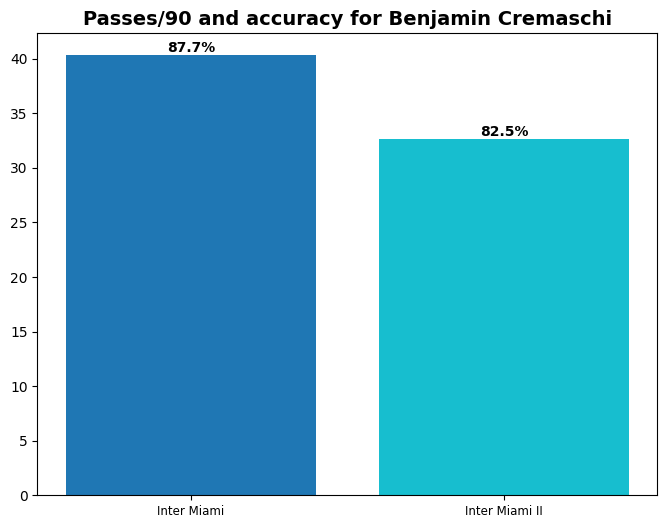

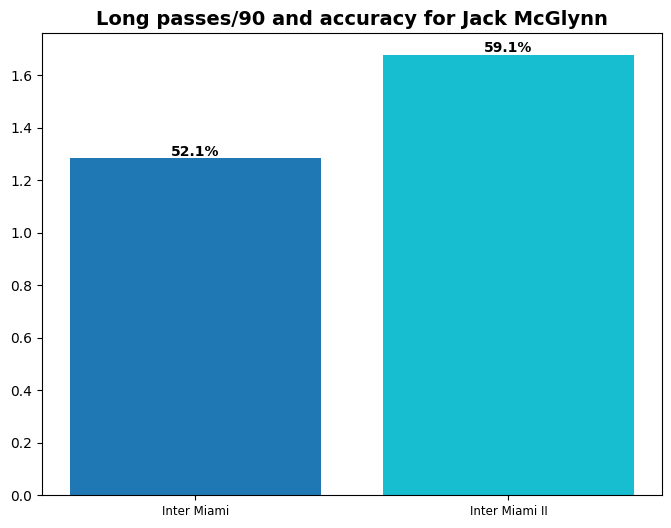

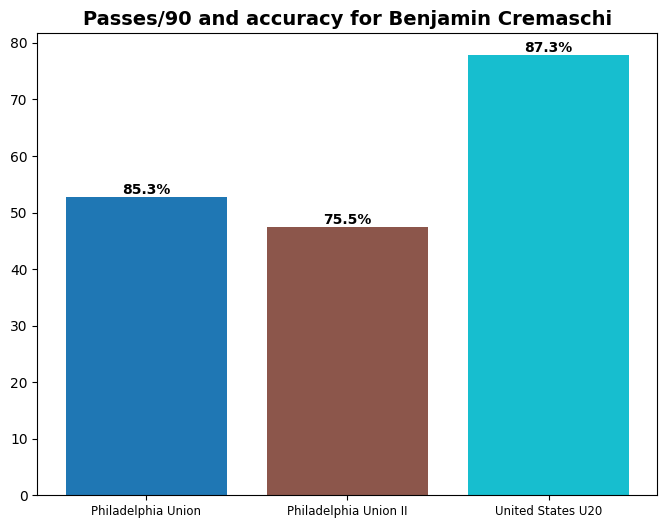

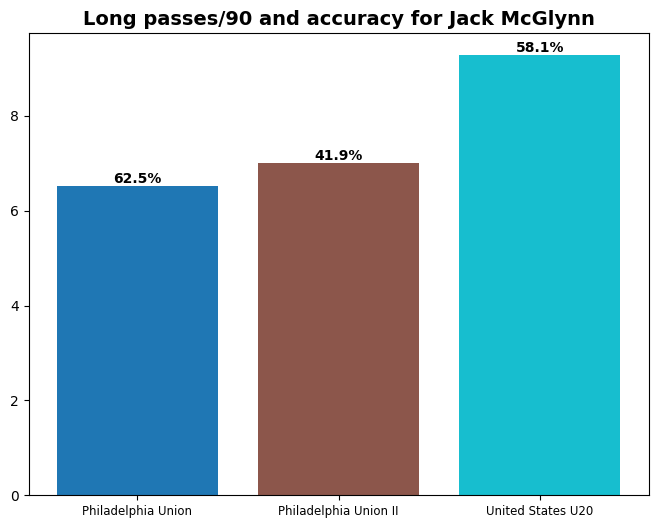

In [98]:
passing_accuracy_per_teams(cremaschi_teams_df, 'Passes/90', 'Passes accurate/90',"Benjamin Cremaschi")
passing_accuracy_per_teams(cremaschi_teams_df, 'Long passes/90', 'Long passes accurate/90',"Jack McGlynn")
passing_accuracy_per_teams(mcglynn_teams_df, 'Passes/90', 'Passes accurate/90',"Benjamin Cremaschi")
passing_accuracy_per_teams(mcglynn_teams_df, 'Long passes/90', 'Long passes accurate/90',"Jack McGlynn")

In [93]:
cremaschi_teams_df

,Minutes played,Total actions/90,Total actions successful/90,Goals/90,Assists/90,Shots/90,Shots on target/90,xG/90,Passes/90,Passes accurate/90,Long passes/90,Long passes accurate/90,Crosses/90,Crosses accurate/90,Dribbles/90,Dribbles successful/90,Duels/90,Duels won/90,Aerial duels/90,Aerial duels won/90,Interceptions/90,Losses/90,Losses own half/90,Recoveries/90,Recoveries opp. half/90,Yellow card/90,Red card/90,Defensive duels/90,Defensive duels won/90,Loose ball duels/90,Loose ball duels won/90,Sliding tackles/90,Sliding tackles successful/90,Clearances/90,Fouls/90,Yellow cards/90,Red cards/90,Shot assists/90,Offensive duels/90,Offensive duels won/90,Touches in penalty area/90,Offsides/90,Progressive runs/90,Fouls suffered/90,Through passes/90,Through passes accurate/90,xA/90,Second assists/90,Passes to final third/90,Passes to final third accurate/90,Passes to penalty area/90,Passes to penalty area accurate/90,Received passes/90,Forward passes/90,Forward passes accurate/90,Back passes/90,Back passes accurate/90
Inter Miami,3366.0,72.219251,46.149733,0.133690,0.133690,1.096257,0.347594,0.139305,40.320856,35.374332,1.283422,0.668449,0.748663,0.240642,2.219251,0.935829,21.764706,9.973262,2.272727,0.962567,2.700535,9.064171,3.716578,5.695187,2.513369,9.064171,0.0,8.048128,5.187166,2.566845,1.096257,0.26738,0.160428,0.695187,1.069519,0.187166,0.0,0.695187,8.877005,2.727273,1.978610,0.13369,1.203209,1.016043,0.695187,0.374332,0.103209,0.026738,3.903743,3.074866,1.497326,0.935829,31.577540,9.331551,7.192513,9.358289,8.796791
Inter Miami II,1181.0,68.204911,40.160881,0.381033,0.152413,1.066892,0.457240,0.087638,32.692633,26.977138,1.676545,0.990686,0.685859,0.304826,3.048264,1.676545,23.471634,11.354784,1.905165,0.990686,2.514818,9.602032,4.115157,6.553768,2.133785,9.068586,0.0,10.592718,6.096528,2.819644,1.066892,0.22862,0.152413,0.762066,1.600339,0.304826,0.0,0.914479,8.154107,3.200677,1.371719,0.00000,1.524132,1.295512,0.609653,0.152413,0.117358,0.152413,4.115157,2.895851,1.295512,0.533446,23.624047,10.821338,7.773074,5.563082,4.877223


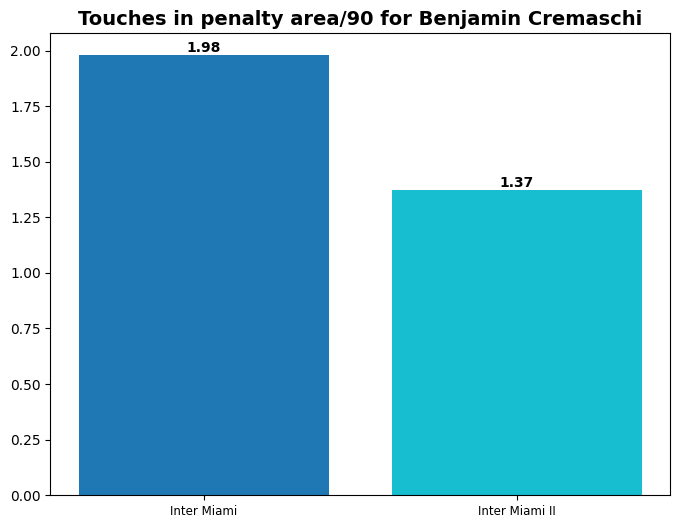

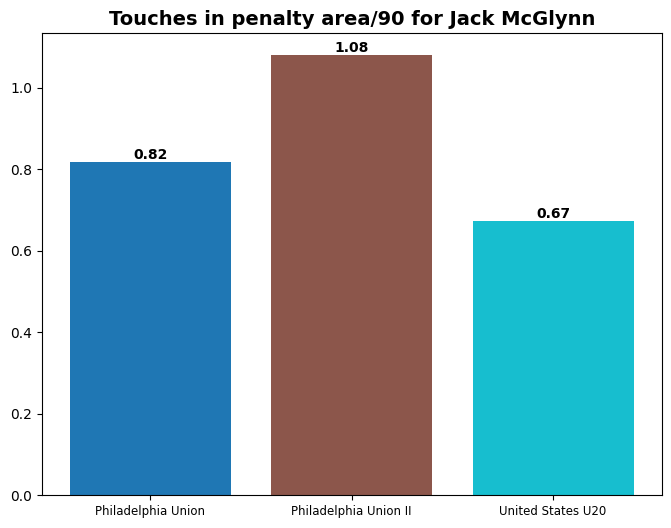

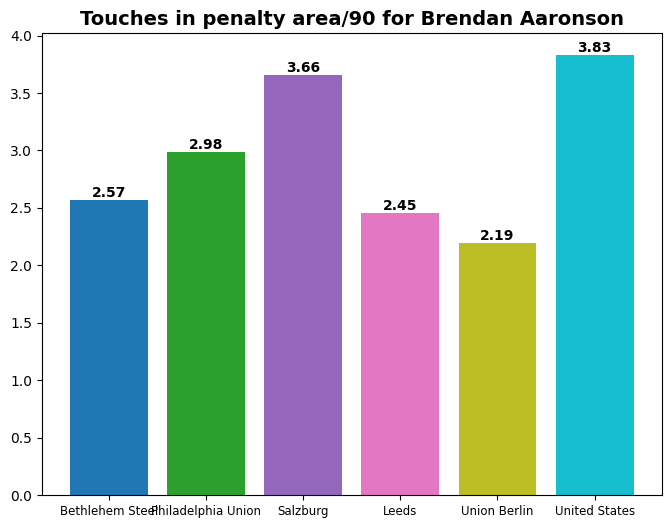

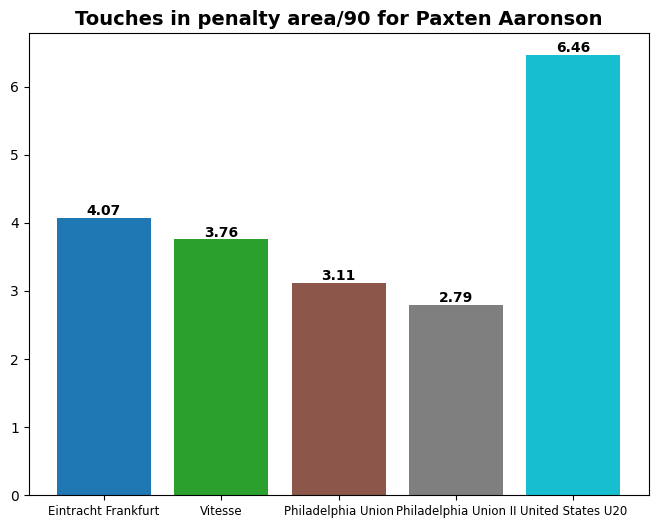

In [42]:
all_metrics =['Goals/90', 'Assists/90', 'Shots/90', 'Shots on target/90', 'xG/90',
       'Passes/90', 'Passes accurate/90', 'Long passes/90',
       'Long passes accurate/90', 'Crosses/90', 'Crosses accurate/90',
       'Dribbles/90', 'Dribbles successful/90', 'Duels/90', 'Duels won/90', 'Interceptions/90',
       'Losses/90', 'Losses own half/90', 'Recoveries/90',
       'Defensive duels/90', 'Defensive duels won/90', 'Clearances/90','Shot assists/90',
       'Offensive duels/90', 'Offensive duels won/90',
       'Touches in penalty area/90', 'Through passes/90', 'Through passes accurate/90',
       'xA/90', 'Second assists/90', 'Passes to final third/90',
       'Passes to final third accurate/90', 'Passes to penalty area/90',
       'Passes to penalty area accurate/90']

dfs = [cremaschi_teams_df, mcglynn_teams_df]
metrics = [
      'Passes to penalty area/90', 'Passes to final third/90', 'Through passes/90', 'Passes/90', 'Passes accurate/90','Long passes/90', 'Long passes accurate/90']

names = ["Benjamin Cremaschi", "Jack McGlynn"]

for metric in metrics:
    visualize_metric_between_teams(cremaschi_teams_df, metric, "Benjamin Cremaschi") 
    visualize_metric_between_teams(mcglynn_teams_df, metric, "Jack McGlynn") 
    visualize_metric_between_teams(aaronson_teams_df, metric, "Brendan Aaronson") 
    visualize_metric_between_teams(paaronson_teams_df, metric, "Paxten Aaronson") 


90s played for each player in the academy

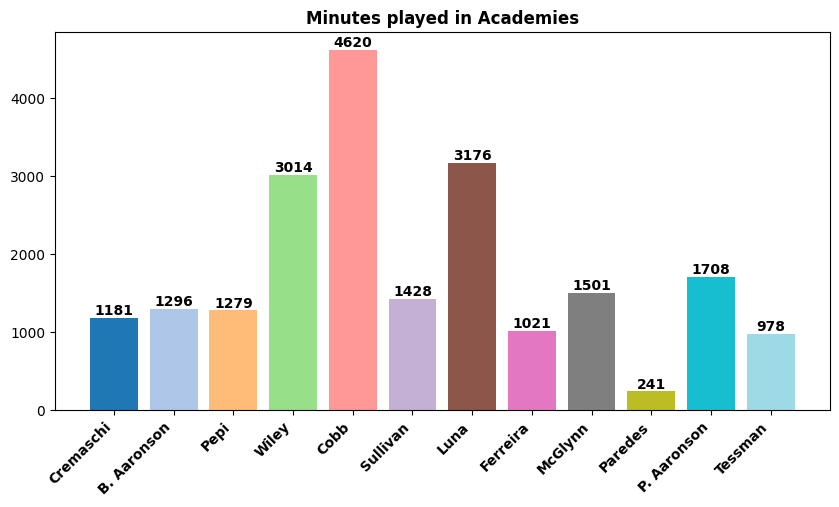

In [43]:
labels = ["Cremaschi", "B. Aaronson", "Pepi", "Wiley", "Cobb", "Sullivan", "Luna", "Ferreira", "McGlynn", "Paredes", "P. Aaronson", "Tessman"]
values = [cremaschi_teams_df.loc['Inter Miami II', 'Minutes played'],
            aaronson_teams_df.loc['Bethlehem Steel', 'Minutes played'],
            pepi_teams_df.loc['North Texas', 'Minutes played'],
            wiley_teams_df.loc['Atlanta United II', 'Minutes played'],
            cobb_teams_df.loc['Atlanta United II', 'Minutes played'],
            sullivan_teams_df.loc['Philadelphia Union II', 'Minutes played'],
            luna_teams_df.loc['El Paso Locomotive', 'Minutes played'],
            ferreira_teams_df.loc['Tulsa Roughnecks', 'Minutes played'],
            mcglynn_teams_df.loc['Philadelphia Union II', 'Minutes played'],
            paredes_teams_df.loc['Loudoun United', 'Minutes played'],
            paaronson_teams_df.loc['Philadelphia Union II', 'Minutes played'],
            tessman_teams_df.loc['North Texas', 'Minutes played'],
            ]

cmap = plt.colormaps['tab20']
colors = cmap(np.linspace(0, 1, len(labels)))

# Create the bar chart with a wider figure
plt.figure(figsize=(10, 6))  # Increase the width of the figure
bars = plt.bar(labels, values, color=colors, width=0.8)
for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom', fontsize=10, fontweight='bold')

# Rotate the x-axis labels for better readability and adjust fontsize
plt.xticks(rotation=45, ha='right', fontsize=10, fontweight='bold')

# Adjust space between labels and the plot
plt.subplots_adjust(bottom=0.25)

# Add titles and labels
plt.title('Minutes played in Academies', fontweight='bold')

# Show the plot
plt.show()


# MLS 2023 Player Data 

In [44]:
mls_df = pd.read_csv("MLS_2023_Players.csv")

Verify column types

In [45]:
print(mls_df.dtypes)

Unnamed: 0                         int64
Player                            object
Nation                            object
Pos                               object
Squad                             object
Age                                int64
Born                               int64
Matches Played                     int64
Starts                             int64
Min                                int64
90s                              float64
Gls                                int64
Ast                                int64
G+A                                int64
G-PK                               int64
PK                                 int64
PKatt                              int64
CrdY                               int64
CrdR                               int64
xG                               float64
npxG                             float64
xAG                              float64
npxG+xAG                         float64
Progressive Carries                int64
Progressive Pass

Drop unnecesary column

In [46]:
mls_df.drop(["Unnamed: 0"], axis=1, inplace=True)

In [47]:
mls_df.head(8)

,Player,Nation,Pos,Squad,Age,Born,Matches Played,Starts,Min,90s,Gls,Ast,G+A,G-PK,PK,PKatt,CrdY,CrdR,xG,npxG,xAG,npxG+xAG,Progressive Carries,Progressive Passes,Progressive Passes Received,Gls 90,Ast 90,G+A 90,G-PK 90,G+A-PK,xG 90,xAG 90,xG+xAG,npxG 90,npxG+xAG 90,A-xAG,Crosses into Penalty Area,Key Passes,Long Passes Attempted,Long Passes Completed,Long Passes Success %,Medium Passes Attempted,Medium Passes Completed,Medium Passes Success %,Passes into Final Third,Passes into Penalty Area,Progressive Passing Distance,Short Passes Attenpted,Short Passes Completed,Short Passes Success %,Total Passes Attempted,Total Passes Completed,Total Passes Success %,Total Passing Distance,xA,Corner Kick Outward,Corner Kick Straight,Corner Kicks,Corner Kicks Inward,Crosses,Dead-ball Passes,Free Kicks Passes,Live-ball Passes,Passes Blocked by Opponent,Passes Completed,Passes Offside,Switches,Through Balls,Throw Ins,% Dribblers Tackled,Challenges Lost,Clearances,Defensive Errors,Dribblers Tackled,Dribbles Challenged,Interceptions,Passes Blocked,Shots Blocked,Tackles,Tackles Att 3rd,Tackles Def 3rd,Tackles Mid 3rd,Tackles Won,Tackles+Interceptions,Total Blocks,Avg Shot Distance,G-xG,Goals / Shots,Goals / Shots on Target,Shots,Shots 90,Shots from Free Kicks,Shots on Target,Shots on Target %,Shots on Target 90,np:G-xG,npxG/Sh,Carries,Carries Total Distance,Carries into Final Third,Carries into Penalty Area,Dispossessed,Miscontrols,Passes Received,Progressive Carrying Distance,Tackles during Take Ons,Tackles during Take Ons %,Take Ons Attempted,Take Ons Succesful,Take Ons Succesful %,Touches,Touches Att 3rd,Touches Att Pen,Touches Def 3rd,Touches Def Pen,Touches Live Ball,Touches Mid 3rd,2CrdY,Aerial Duels Lost,Aerial Duels Won,Aerial Duels Won %,Fouls Commited,Fouls Drawn,Offsides,Own Goals,Penalty Kicks Conceded,Penalty Kicks Won,Recoveries
0,Luis Abram,pe PER,DF,Atlanta Utd,26,1996,22,16,1456,16.2,0,0,0,0,0,0,1,0,0.1,0.1,0.0,0.1,5,29,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.01,0.0,0,1,133,82,61.7,491,459,93.5,20,1,5884,271,250,92.3,907,796,87.8,15646,0.1,0,0,0,0,1,58,23,849,4,796,0,4,0,6,61.5,5,52,0,8,13,16,13,11,12,1,9,2,9,28,24,10.1,-0.1,0.00,NaN,2,0.12,0,0,0.0,0.00,-0.1,0.04,654,2964,4,0,1,3,729,1751,0,0.0,1,0,0.0,1029,18,7,663,149,1029,353,0,14,19,57.6,6,5,1,0,1,0,71
1,Lalas Abubakar,gh GHA,DF,Rapids,28,1994,26,23,1920,21.3,2,0,2,2,0,0,9,1,0.8,0.8,0.2,1.0,5,50,3,0.09,0.00,0.09,0.09,0.09,0.04,0.01,0.05,0.04,0.05,-0.2,1,3,122,64,52.5,526,481,91.4,48,1,5691,432,395,91.4,1109,952,85.8,16684,0.7,0,0,0,0,2,42,13,1067,3,952,0,6,0,29,72.2,5,61,2,13,18,34,6,17,22,0,17,5,11,56,23,11.0,1.2,0.25,0.40,8,0.37,0,5,62.5,0.23,1.2,0.10,712,2835,4,2,0,7,860,1397,1,20.0,5,4,80.0,1289,53,24,649,121,1289,592,1,33,34,50.7,32,7,2,0,0,0,88
2,Daniel Aceves,mx MEX,DF,Fire,21,2001,20,9,853,9.5,0,0,0,0,0,0,1,0,0.3,0.3,0.4,0.7,21,24,34,0.00,0.00,0.00,0.00,0.00,0.04,0.04,0.07,0.04,0.07,-0.4,4,7,49,19,38.8,177,136,76.8,25,7,1827,186,164,88.2,436,321,73.6,5241,0.4,1,0,2,1,33,79,6,352,13,321,5,0,0,71,45.8,13,34,0,11,24,15,13,8,29,0,22,7,20,44,21,14.1,-0.3,0.00,NaN,3,0.32,0,0,0.0,0.00,-0.3,0.11,276,1382,14,1,2,15,292,647,8,53.3,15,6,40.0,568,130,9,197,52,568,245,0,11,10,47.6,10,7,0,0,0,0,51
3,Bryan Acosta,hn HON,MF,Portland Timbers,29,1993,7,5,458,5.1,0,1,1,0,0,0,1,0,0.0,0.0,0.9,0.9,0,19,3,0.00,0.20,0.20,0.00,0.20,0.00,0.17,0.18,0.00,0.18,0.1,0,3,37,29,78.4,103,93,90.3,27,2,929,73,67,91.8,222,192,86.5,3719,0.7,1,0,4,3,6,15,9,206,3,192,1,2,0,2,52.2,11,4,0,12,23,8,2,2,18,2,5,11,12,26,4,32.4,0.0,0.00,NaN,2,0.39,0,0,0.0,0.00,0.0,0.01,133,569,1,0,2,2,139,172,0,0.0,1,1,100.0,266,37,3,59,11,266,170,0,4,8,66.7,14,3,0,0,0,0,34
4,Kellyn Acosta,us USA,MF,LAFC,27,1995,24,18,1498,16.6,0,0,0,0,0,0,5,0,0.6,0.6,1.1,1.7,9,58,24,0.00,0.00,0.00,0.00,0.00,0.04,0.07,0.10,0.04,0.10,-1.1,0,17,111,58,52.3,244,203,83.2,69,2,3093,335,305,91.0,719,584,81.2,9606,1.5,12,0,51,36,58,66,12,652,5,584,1,6,3,3,51.5,16,11,0,17,33,18,20,2,34,6,13,15,20,52,22,24.6,-0.6,0.00,0.00,14,0.84,4,4,28.6,0.24,-0.

Filter players by position, age, minutes played

In [48]:
midfielders_df = mls_df[ (mls_df["90s"] > 15) & (mls_df["Pos"] == "MF") & (mls_df["Age"] <= 23) ]
# midfielders_df = mls_df[ (mls_df["90s"] > 15) & ((mls_df["Pos"] == "MF") | (mls_df["Pos"] == "MF,DF") | (mls_df["Pos"] == "MF,FW")) & ( 18 <= mls_df["Age"] ) & ( mls_df["Age"] <= 25 ) ]
midfielders_df.reset_index(inplace=True, drop=True)
midfielders_df.head(10)


,Player,Nation,Pos,Squad,Age,Born,Matches Played,Starts,Min,90s,Gls,Ast,G+A,G-PK,PK,PKatt,CrdY,CrdR,xG,npxG,xAG,npxG+xAG,Progressive Carries,Progressive Passes,Progressive Passes Received,Gls 90,Ast 90,G+A 90,G-PK 90,G+A-PK,xG 90,xAG 90,xG+xAG,npxG 90,npxG+xAG 90,A-xAG,Crosses into Penalty Area,Key Passes,Long Passes Attempted,Long Passes Completed,Long Passes Success %,Medium Passes Attempted,Medium Passes Completed,Medium Passes Success %,Passes into Final Third,Passes into Penalty Area,Progressive Passing Distance,Short Passes Attenpted,Short Passes Completed,Short Passes Success %,Total Passes Attempted,Total Passes Completed,Total Passes Success %,Total Passing Distance,xA,Corner Kick Outward,Corner Kick Straight,Corner Kicks,Corner Kicks Inward,Crosses,Dead-ball Passes,Free Kicks Passes,Live-ball Passes,Passes Blocked by Opponent,Passes Completed,Passes Offside,Switches,Through Balls,Throw Ins,% Dribblers Tackled,Challenges Lost,Clearances,Defensive Errors,Dribblers Tackled,Dribbles Challenged,Interceptions,Passes Blocked,Shots Blocked,Tackles,Tackles Att 3rd,Tackles Def 3rd,Tackles Mid 3rd,Tackles Won,Tackles+Interceptions,Total Blocks,Avg Shot Distance,G-xG,Goals / Shots,Goals / Shots on Target,Shots,Shots 90,Shots from Free Kicks,Shots on Target,Shots on Target %,Shots on Target 90,np:G-xG,npxG/Sh,Carries,Carries Total Distance,Carries into Final Third,Carries into Penalty Area,Dispossessed,Miscontrols,Passes Received,Progressive Carrying Distance,Tackles during Take Ons,Tackles during Take Ons %,Take Ons Attempted,Take Ons Succesful,Take Ons Succesful %,Touches,Touches Att 3rd,Touches Att Pen,Touches Def 3rd,Touches Def Pen,Touches Live Ball,Touches Mid 3rd,2CrdY,Aerial Duels Lost,Aerial Duels Won,Aerial Duels Won %,Fouls Commited,Fouls Drawn,Offsides,Own Goals,Penalty Kicks Conceded,Penalty Kicks Won,Recoveries
0,Thiago Almada,ar ARG,MF,Atlanta Utd,21,2001,31,31,2728,30.3,11,16,27,9,2,3,6,1,9.5,7.2,13.2,20.3,131,291,170,0.36,0.53,0.89,0.30,0.82,0.31,0.43,0.75,0.24,0.67,2.8,7,93,373,248,66.5,627,509,81.2,201,91,7997,820,741,90.4,1950,1559,79.9,28751,10.9,4,0,67,61,122,168,71,1769,39,1559,13,61,25,15,28.1,23,1,2,9,32,9,10,1,24,8,5,11,14,33,11,23.5,1.5,0.08,0.22,106,3.50,19,41,38.7,1.35,1.8,0.07,1629,10775,131,26,63,70,1856,5135,63,35.8,176,95,54.0,2294,958,76,225,8,2291,1155,1,10,2,16.7,23,56,0,0,0,0,157
1,Frankie Amaya,us USA,MF,NY Red Bulls,22,2000,25,22,1918,21.3,5,0,5,5,0,0,4,0,2.0,2.0,1.7,3.7,21,125,25,0.23,0.00,0.23,0.23,0.23,0.09,0.08,0.17,0.09,0.17,-1.7,0,30,151,73,48.3,361,297,82.3,114,18,4475,328,291,88.7,884,680,76.9,12352,2.6,12,1,41,21,49,95,48,784,15,680,5,5,2,5,48.0,26,29,0,24,50,27,20,3,43,7,15,21,23,70,23,22.2,3.0,0.13,0.56,38,1.78,0,9,23.7,0.42,3.0,0.05,584,2922,30,5,12,26,627,1351,5,17.2,29,19,65.5,1107,335,23,181,40,1107,601,0,19,14,42.4,32,17,0,0,0,0,177
2,César Araujo,uy URU,MF,Orlando City,21,2001,33,31,2730,30.3,1,3,4,1,0,0,8,0,1.4,1.4,1.9,3.3,21,155,38,0.03,0.10,0.13,0.03,0.13,0.05,0.06,0.11,0.05,0.11,1.1,0,22,239,148,61.9,671,571,85.1,173,11,9049,709,658,92.8,1686,1404,83.3,24923,2.3,0,0,0,0,11,139,54,1543,25,1404,4,23,13,85,31.9,62,31,0,29,91,23,33,7,51,8,20,23,31,74,40,18.2,-0.4,0.05,0.17,21,0.69,0,6,28.6,0.20,-0.4,0.07,1075,4580,35,3,14,22,1325,2177,7,26.9,26,13,50.0,1929,356,29,477,69,1929,1114,0,29,17,37.0,47,100,1,0,0,0,223
3,Njabulo Blom,za RSA,MF,St. Louis,23,1999,26,21,1915,21.3,1,0,1,1,0,0,6,0,0.4,0.4,0.3,0.7,8,81,17,0.05,0.00,0.05,0.05,0.05,0.02,0.02,0.03,0.02,0.03,-0.3,0,12,78,49,62.8,268,230,85.8,90,1,3766,350,306,87.4,726,600,82.6,9969,0.4,0,0,0,0,6,12,9,714,12,600,0,3,1,3,38.3,29,22,0,18,47,49,25,5,45,8,22,15,19,94,30,26.1,0.6,0.08,0.33,13,0.61,0,3,23.1,0.14,0.6,0.03,476,2419,18,1,20,35,490,900,8,22.9,35,24,68.6,965,157,4,246,55,965,581,0,16,8,33.3,21,22,0,0,0,0,185
4,Cristian Cásseres Jr.,ve VEN,MF,NY Red Bulls,23,2000,17,16,1440,16.0,1,1,2,1,0,0,7,0,1.2,1.2,3.5,4.7,27,122,40,0.06,0.06,0.12,0.06,0.12,0.08,0.22,0.29,0.08,0.29,-2.5,4,34,130,65,50.0,290,217,74.8,98,21,4211,308,27

In [49]:
midfielders_df.columns.tolist()

['Player',
 'Nation',
 'Pos',
 'Squad',
 'Age',
 'Born',
 'Matches Played',
 'Starts',
 'Min',
 '90s',
 'Gls',
 'Ast',
 'G+A',
 'G-PK',
 'PK',
 'PKatt',
 'CrdY',
 'CrdR',
 'xG',
 'npxG',
 'xAG',
 'npxG+xAG',
 'Progressive Carries',
 'Progressive Passes',
 'Progressive Passes Received',
 'Gls 90',
 'Ast 90',
 'G+A 90',
 'G-PK 90',
 'G+A-PK',
 'xG 90',
 'xAG 90',
 'xG+xAG',
 'npxG 90',
 'npxG+xAG 90',
 'A-xAG',
 'Crosses into Penalty Area',
 'Key Passes',
 'Long Passes Attempted',
 'Long Passes Completed',
 'Long Passes Success %',
 'Medium Passes Attempted',
 'Medium Passes Completed',
 'Medium Passes Success %',
 'Passes into Final Third',
 'Passes into Penalty Area',
 'Progressive Passing Distance',
 'Short Passes Attenpted',
 'Short Passes Completed',
 'Short Passes Success %',
 'Total Passes Attempted',
 'Total Passes Completed',
 'Total Passes Success %',
 'Total Passing Distance',
 'xA',
 'Corner Kick Outward',
 'Corner Kick Straight',
 'Corner Kicks',
 'Corner Kicks Inward',
 'Cr

Filter midfielders by columns

In [50]:
cols = ['Player',
 'Squad',
 'Age',
 'Min',
 '90s',
 'Gls',
 'Ast',
 'xG',
 'Long Passes Attempted',
 'Long Passes Completed',
 'Passes into Final Third',
 'Passes into Penalty Area',
 'Total Passes Attempted',
 'Total Passes Completed',
 'xA',
 'Crosses',
 'Passes Completed',
 'Through Balls',
 'Clearances',
 'Interceptions',
 'Shots',
 'Shots on Target',
 'Touches Att Pen',
 "Recoveries",
 "Fouls Commited",
 "Fouls Drawn"]

midfielders_df = midfielders_df[cols]

Normalize metrics to 90 minutes

In [51]:
# Convert columns from index 4 onwards to float64 individually
for col in midfielders_df.columns[4:]:
    midfielders_df[col] = pd.to_numeric(midfielders_df[col], errors='coerce').astype('float64')
    
# Perform the division, replacing any 0s in the '90s' column to avoid division by zero
midfielders_df.iloc[:, 5:] = midfielders_df.iloc[:, 5:].div(midfielders_df['90s'].replace(0, np.nan), axis=0)

midfielders_df.head()

,Player,Squad,Age,Min,90s,Gls,Ast,xG,Long Passes Attempted,Long Passes Completed,Passes into Final Third,Passes into Penalty Area,Total Passes Attempted,Total Passes Completed,xA,Crosses,Passes Completed,Through Balls,Clearances,Interceptions,Shots,Shots on Target,Touches Att Pen,Recoveries,Fouls Commited,Fouls Drawn
0,Thiago Almada,Atlanta Utd,21,2728,30.3,0.363036,0.528053,0.313531,12.310231,8.184818,6.633663,3.003300,64.356436,51.452145,0.359736,4.026403,51.452145,0.825083,0.033003,0.297030,3.498350,1.353135,2.508251,5.181518,0.759076,1.848185
1,Frankie Amaya,NY Red Bulls,22,1918,21.3,0.234742,0.000000,0.093897,7.089202,3.427230,5.352113,0.845070,41.502347,31.924883,0.122066,2.300469,31.924883,0.093897,1.361502,1.267606,1.784038,0.422535,1.079812,8.309859,1.502347,0.798122
2,César Araujo,Orlando City,21,2730,30.3,0.033003,0.099010,0.046205,7.887789,4.884488,5.709571,0.363036,55.643564,46.336634,0.075908,0.363036,46.336634,0.429043,1.023102,0.759076,0.693069,0.198020,0.957096,7.359736,1.551155,3.300330
3,Njabulo Blom,St. Louis,23,1915,21.3,0.046948,0.000000,0.018779,3.661972,2.300469,4.225352,0.046948,34.084507,28.169014,0.018779,0.281690,28.169014,0.046948,1.032864,2.300469,0.610329,0.140845,0.187793,8.685446,0.985915,1.032864
4,Cristian Cásseres Jr.,NY Red Bulls,23,1440,16.0,0.062500,0.062500,0.075000,8.125000,4.062500,6.125000,1.312500,48.875000,35.812500,0.237500,5.000000,35.812500,0.375000,0.750000,1.187500,1.500000,0.625000,0.937500,7.625000,1.812500,1.937500


# Comparison Academy vs MLS

Metrics for each DF

MLS / Academy

'Min' : 'Minutes played'

'Gls' : 'Goals/90'

'Ast' : 'Assists/90'

'xG'  : 'xG/90'

'Long Passes Attempted' : 'Long passes/90'

'Long Passes Completed' : 'Long passes accurate/90'

'Passes into Final Third' : 'Passes to final third/90'

'Passes into Penalty Area' : 'Passes to penalty area/90'

'Total Passes Attempted', 'Passes/90'

'Total Passes Completed', 'Passes accurate/90'

'xA' : 'xA/90'

'Crosses' :  'Crosses/90'

'Through Balls' : 'Through passes/90' 

'Clearances' : 'Clearances/90' 

'Interceptions' :  'Interceptions/90'

'Shots' : 'Shots/90'

'Shots on Target' : 'Shots on target/90'

'Touches Att Pen' : 'Touches in penalty area/90'

"Recoveries" : 'Recoveries/90'

"Fouls Commited" : 'Fouls/90'

"Fouls Drawn", : 'Fouls suffered/90'

Interceptions vs Recoveries

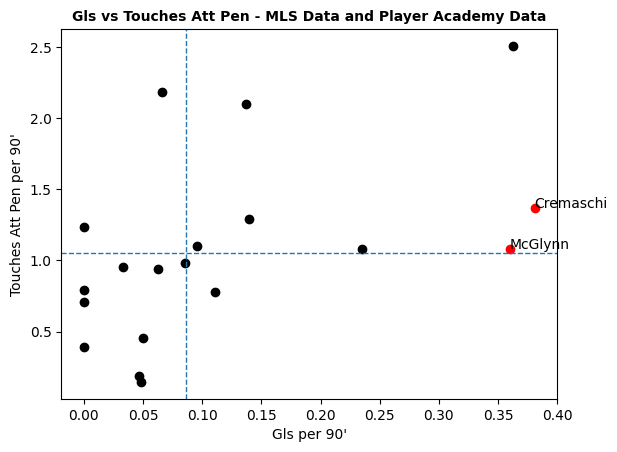

In [52]:
scatter_mls_vs_aca(midfielders_df, cremaschi_teams_df, "Inter Miami II", mcglynn_teams_df, "Philadelphia Union II", "Gls", "Touches Att Pen", "Goals/90", "Touches in penalty area/90")

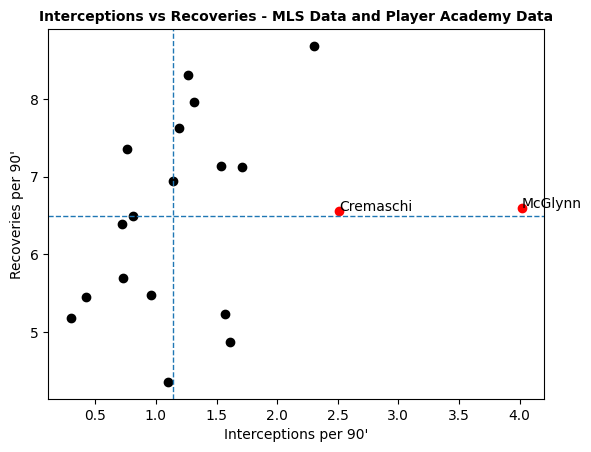

In [53]:
scatter_mls_vs_aca(midfielders_df, cremaschi_teams_df, "Inter Miami II", mcglynn_teams_df, "Philadelphia Union II", "Interceptions", "Recoveries", "Interceptions/90", "Recoveries/90")

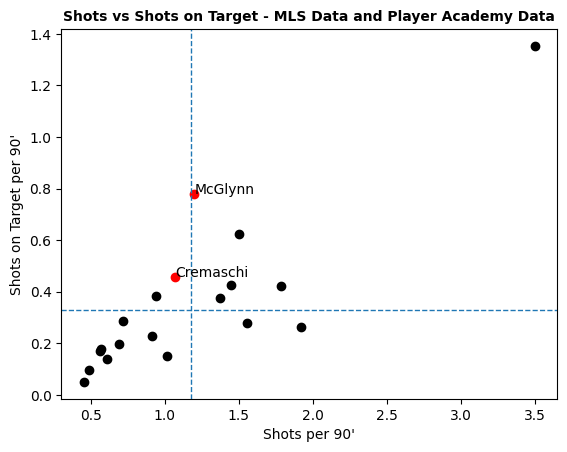

In [54]:
scatter_mls_vs_aca(midfielders_df, cremaschi_teams_df, "Inter Miami II", mcglynn_teams_df, "Philadelphia Union II", "Shots", "Shots on Target", "Shots/90", "Shots on target/90")

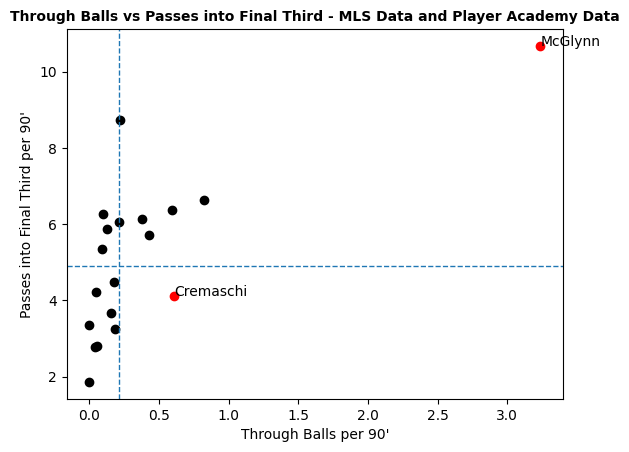

In [55]:
scatter_mls_vs_aca(midfielders_df, cremaschi_teams_df, "Inter Miami II", mcglynn_teams_df, "Philadelphia Union II", "Through Balls", "Passes into Final Third", "Through passes/90", "Passes to final third/90")

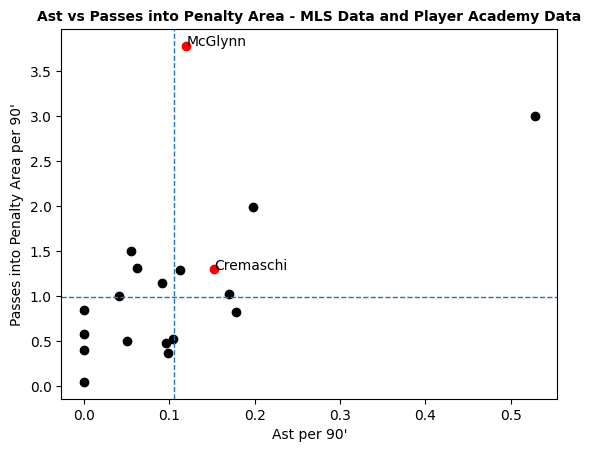

In [56]:
scatter_mls_vs_aca(midfielders_df, cremaschi_teams_df, "Inter Miami II", mcglynn_teams_df, "Philadelphia Union II", "Ast", "Passes into Penalty Area", "Assists/90", "Passes to penalty area/90")

Radar Chart

In [57]:
cremaschi_teams_df.columns

Index(['Minutes played', 'Total actions/90', 'Total actions successful/90',
       'Goals/90', 'Assists/90', 'Shots/90', 'Shots on target/90', 'xG/90',
       'Passes/90', 'Passes accurate/90', 'Long passes/90',
       'Long passes accurate/90', 'Crosses/90', 'Crosses accurate/90',
       'Dribbles/90', 'Dribbles successful/90', 'Duels/90', 'Duels won/90',
       'Aerial duels/90', 'Aerial duels won/90', 'Interceptions/90',
       'Losses/90', 'Losses own half/90', 'Recoveries/90',
       'Recoveries opp. half/90', 'Yellow card/90', 'Red card/90',
       'Defensive duels/90', 'Defensive duels won/90', 'Loose ball duels/90',
       'Loose ball duels won/90', 'Sliding tackles/90',
       'Sliding tackles successful/90', 'Clearances/90', 'Fouls/90',
       'Yellow cards/90', 'Red cards/90', 'Shot assists/90',
       'Offensive duels/90', 'Offensive duels won/90',
       'Touches in penalty area/90', 'Offsides/90', 'Progressive runs/90',
       'Fouls suffered/90', 'Through passes/90', 'Th

/usr/local/python/3.10.13/lib/python3.10/site-packages/soccerplots/radar_chart.py:397: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if values[i] >= range_list[-1]:
/usr/local/python/3.10.13/lib/python3.10/site-packages/soccerplots/radar_chart.py:401: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif values[i] <= range_list[0]:
/usr/local/python/3.10.13/lib/python3.10/site-packages/soccerplots/radar_chart.py:407: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by posi

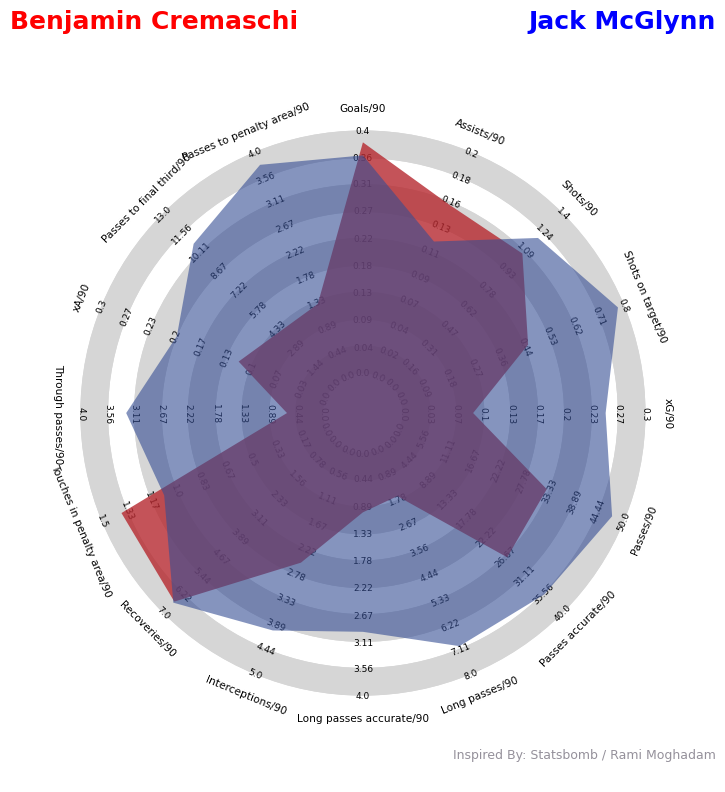

In [58]:
## parameter names
metrics = ['Goals/90', 'Assists/90', 'Shots/90', 'Shots on target/90', 'xG/90',
       'Passes/90', 'Passes accurate/90', 'Long passes/90',
       'Long passes accurate/90',
       'Interceptions/90',
       'Recoveries/90',
       'Touches in penalty area/90',  'Through passes/90',
       'xA/90', 'Passes to final third/90', 'Passes to penalty area/90']

## range values
ranges = [(0, 0.4), (0.0, 0.2), (0, 1.4), (0, 0.8), (0, 0.3), (0, 50), (0.0, 40), (0, 8),  (0.0, 4),  (0.0, 5) ,  (0.0, 7) ,  (0.0, 1.5) ,  (0.0, 4) ,  (0.0, 0.3) ,  (0.0, 13), (0.0, 4)]

two_player_radar_chart(metrics, ranges, cremaschi_teams_df, "Inter Miami II", "Benjamin Cremaschi", mcglynn_teams_df, "Philadelphia Union II", "Jack McGlynn")

https://github.com/Slothfulwave612/soccerplots/blob/master/docs/radar_chart.md